# For ptychosaxs simulated data

In [2]:
# coding: utf-8
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib


import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from matplotlib import colors
import matplotlib.pyplot as plt

# from cupyx.scipy.signal import convolve2d as conv2
# import cupy as cp

# from scipy.signal import convolve2d as conv2np
import random

from IPython.display import clear_output

from multiprocessing import Pool, get_context
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from joblib import Parallel, delayed

from pathlib import Path

import h5py
import hdf5plugin

In [3]:
#upper and lower bar bounds for diffraction panels
lbound,ubound=(23,38),(235,250)

In [3]:
plt.rcParams["image.cmap"] = "jet"

#reduce size of diffraction patterns
red=True

#save model pth
save=True

#setting path
#path='/mnt/micdata2/12IDC/ptychosaxs'
#path=Path('/net/micdata/data2/12IDC/ptychosaxs')

# Define the path
path = Path("Y:/ptychosaxs")  # Use forward slashes, Path will adjust for the OS

# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

Y:\ptychosaxs\trained_model


In [1]:
# Parameters
num = 13# 13, scanned with 400, subtracted out probe; 12, scanned with 400 lattice; 11, 288 lattice size (2x other scanned samples); 10, scanned with scaled by q^4; 9, scanned with no pinhole extra convolution; 8, scanned sample, pinhole extra convolution; 5, cindy; 4, chansong
data_location=path / f'data/diff_sim/{num}/'
print(data_location)
filenames=os.listdir(data_location)
filenames=[data_location / f for f in filenames][:500]
# Combine into HDF5

output_file=path / f"data/combined_data_{num}_500.h5"
if output_file.exists():
    print('combined file already exists')
else:
    with h5py.File(output_file, "w") as h5f:
        for i, file_path in enumerate(filenames):
            data = np.load(file_path)
            h5f.create_dataset(f"convDP_{i}", data=data["convDP"])
            h5f.create_dataset(f"pinholeDP_{i}", data=data["pinholeDP"])

NameError: name 'path' is not defined

In [ ]:
# Later: Load from HDF5
# Load data with progress bar
with h5py.File(output_file, "r") as h5f:
    # Get the keys (dataset names)
    dataset_keys = list(h5f.keys())
    num_datasets = len(dataset_keys) // 2  # Assuming convDP and pinholeDP pairs
    print(dataset_keys)
    print(num_datasets)
    # Initialize empty lists for the data
    conv_DPs = []
    pinhole_DPs = []

    # Use tqdm for progress tracking
    for i in tqdm(range(num_datasets), desc="Loading HDF5 datasets"):
        conv_DPs.append(h5f[f"convDP_{i}"][:])  # Load convDP dataset
        pinhole_DPs.append(h5f[f"pinholeDP_{i}"][:])  # Load pinholeDP dataset

['convDP_0', 'convDP_1', 'convDP_10', 'convDP_100', 'convDP_1000', 'convDP_10000', 'convDP_10001', 'convDP_10002', 'convDP_10003', 'convDP_10004', 'convDP_10005', 'convDP_10006', 'convDP_10007', 'convDP_10008', 'convDP_10009', 'convDP_1001', 'convDP_10010', 'convDP_10011', 'convDP_10012', 'convDP_10013', 'convDP_10014', 'convDP_10015', 'convDP_10016', 'convDP_10017', 'convDP_10018', 'convDP_10019', 'convDP_1002', 'convDP_10020', 'convDP_10021', 'convDP_10022', 'convDP_10023', 'convDP_10024', 'convDP_10025', 'convDP_10026', 'convDP_10027', 'convDP_10028', 'convDP_10029', 'convDP_1003', 'convDP_10030', 'convDP_10031', 'convDP_10032', 'convDP_10033', 'convDP_10034', 'convDP_10035', 'convDP_10036', 'convDP_10037', 'convDP_10038', 'convDP_10039', 'convDP_1004', 'convDP_10040', 'convDP_10041', 'convDP_10042', 'convDP_10043', 'convDP_10044', 'convDP_10045', 'convDP_10046', 'convDP_10047', 'convDP_10048', 'convDP_10049', 'convDP_1005', 'convDP_10050', 'convDP_10051', 'convDP_10052', 'convDP_10

  8%|▊         | 1273/15015 [03:04<29:55,  7.65it/s]  

In [ ]:


# Collect filenames
filenames = list(data_location.glob("*.npz"))

# Use joblib for parallel processing
num_processes = 8
results = Parallel(n_jobs=num_processes)(
    delayed(load_data)(file_path) for file_path in tqdm(filenames)
)

# Filter out failed loads
loaded_data = [res for res in results if res is not None]

# Example usage
conv_DPs = np.array([entry["convDP"] for entry in loaded_data])
pinhole_DPs = np.array([entry["pinholeDP"] for entry in loaded_data])

print(f"Loaded {len(loaded_data)} datasets successfully.")

  4%|▍         | 576/15015 [02:01<49:59,  4.81it/s]  

In [ ]:
#load convoluted and ideal diffraction patterns
print('Loading data...')
numthreads=4
def load_data(f):
    try:
        print(f"Loading file: {f}")
        data = np.load(f)
        convDP = data['convDP']
        pinholeDP = data['pinholeDP']
        return convDP, pinholeDP
    except Exception as e:
        print(f"Error loading file {f}: {e}")
        return None

#with Pool(numthreads) as pool:
#    print(numthreads)
#    pool.map(load_data, filenames)
with ThreadPoolExecutor(max_workers=numthreads) as executor:
    results = list(executor.map(load_data, filenames))
loaded_data = [r for r in results if r is not None]
print(f"Loaded {len(loaded_data)} datasets successfully")   
# conv_DPs=np.asarray([np.load(filenames[i])['convDP'] for i in tqdm(range(1,15001))])#,dtype=np.float32)
# ideal_DPs=np.asarray([np.load(filenames[i])['pinholeDP'] for i in tqdm(range(1,15001))])#,dtype=np.float32)



Loading data...
Y:\ptychosaxs\data\diff_sim\13
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00001.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00002.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00003.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00004.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00005.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00006.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00007.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00008.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00009.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00010.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00011.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_hanning_conv_00012.npz
Loading file: Y:\ptychosaxs\data\diff_sim\13\output_h

KeyboardInterrupt: 

In [5]:
# conv_DPs = np.concatenate((conv_DPs,conv_DPs_extra),axis=0)
# ideal_DPs = np.concatenate((ideal_DPs,ideal_DPs_extra),axis=0)
# #loading probes is much slower
# #probe_DPs=np.asarray([np.load('/mnt/micdata2/12IDC/ptychosaxs/data/diff_sim/{}/output_hanning_conv_{:05d}.npz'.format(num,i))['psf'] for i in tqdm(range(1,total_patterns))])#,dtype=np.float32)
# #probe_DPs=np.asarray([np.load('/mnt/micdata2/12IDC/ptychosaxs/data/diff_sim/{}/output_hanning_conv_{:05d}.npz'.format(num,i))['probe'] for i in tqdm(range(1,total_patterns))])#,dtype=np.float32)



In [6]:
probe_DPs=np.ones(conv_DPs.shape)
#deal detector mask
#chansong
#conv_DPs=np.asarray([replace_2d_array_values_by_row_indices(replace_2d_array_values_by_row_indices(conv_DPs[i],ubound[0],ubound[1]),lbound[0],lbound[1]) for i in range(0,len(conv_DPs))])
#cindy
conv_DPs2=np.asarray([replace_2d_array_values_by_column_indices(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_row_indices(replace_2d_array_values_by_row_indices(conv_DPs[i],0,8),247,255),0,8),247,255) for i in range(0,len(conv_DPs))])

print(conv_DPs2.shape)

# center_mask=create_circular_mask(conv_DPs[0], 48)
# conv_DPs=np.asarray([center_mask*c for c in conv_DPs])
# ideal_DPs=np.asarray([center_mask*c for c in ideal_DPs])


#shuffle data correspondingly
indices = np.arange(conv_DPs2.shape[0])
np.random.shuffle(indices)
conv_DPs2 = conv_DPs2[indices]
ideal_DPs2 = ideal_DPs[indices]
probe_DPs2=probe_DPs[indices]

# acquire phase and amplitude of images
def log10_custom_basic(arr):
    return np.where(arr > 0, np.log10(arr),0)
def log10_custom(arr):
    # Create a mask for positive values
    positive_mask = arr > 0
    
    # Initialize result array
    result = np.zeros_like(arr, dtype=float)
    
    # Calculate log10 only on positive values
    log10_positive = np.log10(arr[positive_mask])
    
    # Find the minimum log10 value from the positive entries
    min_log10_value = log10_positive.min() if log10_positive.size > 0 else 0
    
    # Set positive entries to their log10 values
    result[positive_mask] = log10_positive
    
    # Set non-positive entries to the minimum log10 value
    result[~positive_mask] = min_log10_value
    
    return result

'''
Explanation
We calculate the log10 values only on positive entries.
min_log10_value holds the minimum log10 value among positive entries.
We assign min_log10_value to any non-positive entries in the array, so negative or zero values get this minimum value.
This approach ensures the result is smoothly scaled with log10 values, using the minimum log10 value for non-positive entries. Let me know if you'd like to test it!
'''
#amp_conv = np.log10_custom(conv_DPs2+np.min(conv_DPs2[conv_DPs2>0]))
#amp_ideal = np.log10(ideal_DPs2+np.min(ideal_DPs2[ideal_DPs2>0]))
amp_conv = log10_custom(conv_DPs2)#+np.min(conv_DPs2[conv_DPs2>0]))
amp_ideal = log10_custom(ideal_DPs2)#+np.min(ideal_DPs2[ideal_DPs2>0]))
amp_probe = np.abs(probe_DPs)
phase_conv = np.angle(conv_DPs2)
phase_ideal = np.angle(ideal_DPs2)
phase_probe = np.angle(probe_DPs)



(15000, 256, 256)


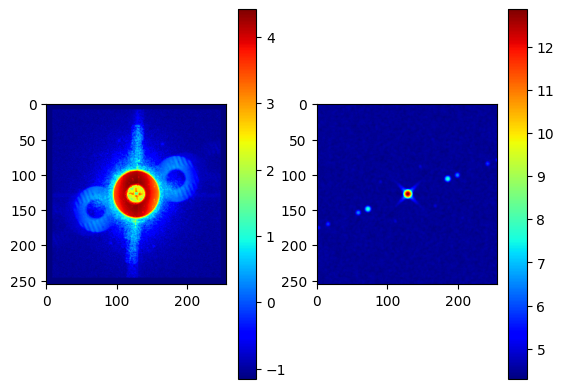

In [7]:
fig,ax=plt.subplots(1,2)
ri=random.randint(0,len(amp_conv))
im1=ax[0].imshow(amp_conv[ri])
im2=ax[1].imshow(amp_ideal[ri])
plt.colorbar(im1)
plt.colorbar(im2)
plt.show()

In [8]:
if red:
    print("Resizing...")
    amp_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_ideal)])
    amp_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_conv)])
    amp_probe_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_probe)])
else:
    print("No filtering and resizing...")
    amp_ideal_red=amp_ideal
    amp_conv_red=amp_conv
    amp_probe_red=amp_probe
    

print(f'maximum in ideal patterns: {np.max(amp_ideal_red[ri])}')
print(f'maximum in conv patterns: {np.max(amp_conv_red[ri])}')


Resizing...


100%|█████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:25<00:00, 598.60it/s]


maximum in ideal patterns: 12.86194339467995
maximum in conv patterns: 4.41616955997637


/tmp/ipykernel_3205861/3612944665.py:15: RuntimeWarning: invalid value encountered in divide
  amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])


normalized maximum in ideal/output patterns: 1.0
normalized maximum in conv/input patterns: 1.0


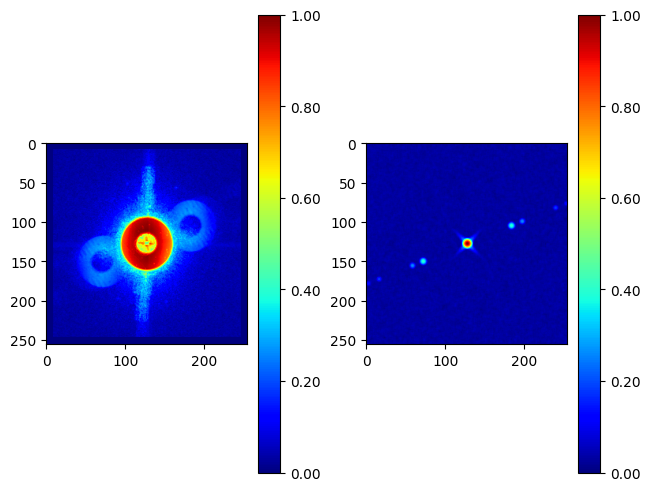

In [9]:
#NORMALIZE OUTPUT FROM 0 to 1
ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_ideal_red])
ideal_constants=np.asarray([(np.min(a)) for a in amp_ideal_red])
amp_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_ideal_red])


# #NORMALIZE INPUT FROM 0 to 1
conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_conv_red])
conv_constants=np.asarray([(np.min(a)) for a in amp_conv_red])
amp_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_conv_red])

# #NORMALIZE INPUT FROM 0 to 1
probe_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_probe_red])
probe_constants=np.asarray([(np.min(a)) for a in amp_probe_red])
amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])


print(f'normalized maximum in ideal/output patterns: {np.max(amp_ideal_red[0])}')
print(f'normalized maximum in conv/input patterns: {np.max(amp_conv_red[0])}')

fig,ax=plt.subplots(1,2,layout='constrained')
im1=ax[1].imshow(amp_ideal_red[0])#,norm=colors.LogNorm())
plt.colorbar(im1, ax=ax[1], format='%.2f')
im2=ax[0].imshow(amp_conv_red[0])#,norm=colors.LogNorm())
plt.colorbar(im2, ax=ax[0], format='%.2f')
plt.show()

In [10]:
NTEST = conv_DPs.shape[0]//4
NTRAIN = conv_DPs.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

11250 3750 1875


In [11]:
EPOCHS = 512
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)



GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [12]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # To inverse the transformation:
# original_data = scaler.inverse_transform(scaled_data)

9441
False
False


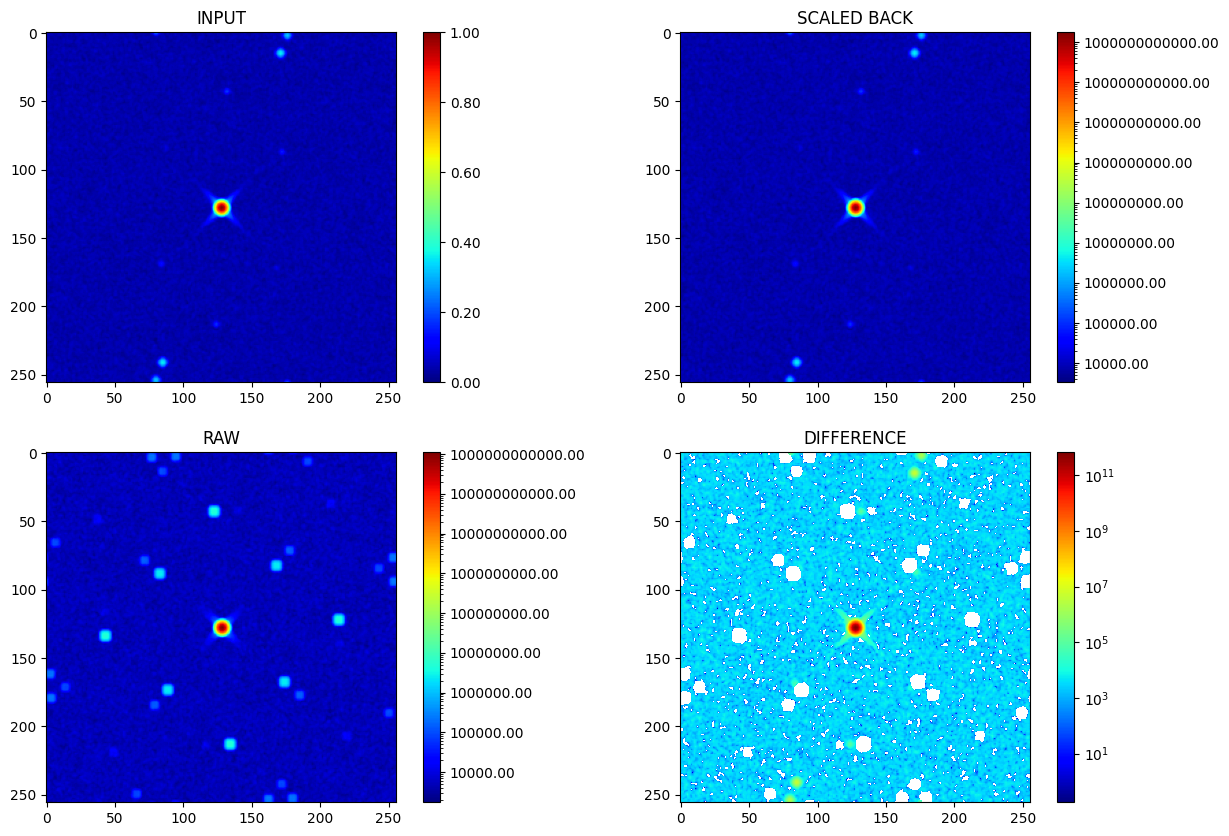

In [13]:
amp_ideal_red.shape,ideal_scale_factors.shape

def scale_back(dp,scale_factor,constant):
    temp=dp*scale_factor + constant
    temp=10**(temp)
    return temp

fig,ax=plt.subplots(2,2,figsize=(15,10))
index=random.randint(0,len(amp_ideal_red))
print(index)
image,scale,constant=amp_ideal_red[index],ideal_scale_factors[index],ideal_constants[index]
orig=ideal_DPs2[index]
print(np.allclose(scale_back(image,scale,constant),orig))
print(np.allclose(orig,scale_back(image,scale,constant)))
im=ax[0][0].imshow(amp_ideal_red[index])#,norm=colors.LogNorm())
plt.colorbar(im, ax=ax[0][0], format='%.2f')
ax[0][0].set_title('INPUT')
im=ax[0][1].imshow(scale_back(image,scale,constant),norm=colors.LogNorm())
plt.colorbar(im, ax=ax[0][1], format='%.2f')
ax[0][1].set_title('SCALED BACK')
im=ax[1][0].imshow(orig,norm=colors.LogNorm())
plt.colorbar(im, ax=ax[1][0], format='%.2f')
ax[1][0].set_title('RAW')
im=ax[1][1].imshow(scale_back(image,scale,constant)-orig,norm=colors.LogNorm())
plt.colorbar(im, ax=ax[1][1])
ax[1][1].set_title('DIFFERENCE')
plt.show()



In [14]:
tst_start = amp_conv_red.shape[0]-NTEST


X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]
probe_scale_factors
probe_constants

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]


ntrain=X_train.shape[0]
ntest=X_test.shape[0]



X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)


#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


# #combine into two channels
# X_combined_train_tensor=torch.cat([X_train_tensor, Xp_train_tensor], dim=1)
# X_combined_test_tensor=torch.cat([X_test_tensor, Xp_test_tensor], dim=1)
# # print(X_combined_train_tensor.shape)


# train_data = TensorDataset(X_combined_train_tensor,Y_I_train_tensor)
# test_data = TensorDataset(X_combined_test_tensor)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)#Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


#N_TRAIN = X_combined_train_tensor.shape[0]
N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([11250, 1, 256, 256]) torch.Size([11250, 1, 256, 256]) torch.Size([11250, 1, 256, 256])
9375 2 1875 3750


In [15]:
# Self-Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)  # B, N, C'
        key = self.key_conv(x).view(batch_size, -1, width * height)  # B, C', N
        attention = torch.bmm(query, key)  # B, N, N (N = width*height)
        attention = F.softmax(attention, dim=-1)
        
        value = self.value_conv(x).view(batch_size, -1, width * height)  # B, C, N
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B, C, N
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x
        return out

class LocalSelfAttention(nn.Module):
    def __init__(self, in_dim, local_size=32, reduction_ratio=8):
        super(LocalSelfAttention, self).__init__()
        self.local_size = local_size  # Define the local region size
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // reduction_ratio, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // reduction_ratio, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()

        # Compute patches of local_size x local_size
        for i in range(0, H, self.local_size):
            for j in range(0, W, self.local_size):
                x_patch = x[:, :, i:i + self.local_size, j:j + self.local_size]

                # If the patch is smaller than local_size, ignore it
                if x_patch.size(2) < self.local_size or x_patch.size(3) < self.local_size:
                    continue

                query = self.query_conv(x_patch).view(batch_size, -1, self.local_size * self.local_size).permute(0, 2, 1)
                key = self.key_conv(x_patch).view(batch_size, -1, self.local_size * self.local_size)
                value = self.value_conv(x_patch).view(batch_size, -1, self.local_size * self.local_size)

                attention = torch.bmm(query, key) / (C // self.local_size) ** 0.5
                attention = F.softmax(attention, dim=-1)

                out = torch.bmm(value, attention.permute(0, 2, 1))
                out = out.view(batch_size, C, self.local_size, self.local_size)

                x[:, :, i:i + self.local_size, j:j + self.local_size] = self.gamma * out + x_patch

        return x

In [16]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'Kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise average pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Shape: (B, 1, H, W)
        
        # Channel-wise max pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Shape: (B, 1, H, W)
        
        # Concatenate along the channel dimension
        concat_out = torch.cat([avg_out, max_out], dim=1)  # Shape: (B, 2, H, W)
        
        # Apply a convolution layer followed by a sigmoid activation
        attention_map = self.conv(concat_out)  # Shape: (B, 1, H, W)
        attention_map = self.sigmoid(attention_map)  # Shape: (B, 1, H, W)
        
        # Multiply attention map with the original input feature map
        return x * attention_map  # Shape: (B, C, H, W)

In [17]:
#NO PROBE NETWORK
no_probe=True
if no_probe:
    nconv=64
    class recon_model(nn.Module):
       def __init__(self):
           super(recon_model, self).__init__()
    
           def conv_block(in_channels, out_channels):
                block = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=(1,1)),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                )
                return block
        
               
           def up_conv(in_channels, out_channels):
               return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
               
           def conv_last(in_channels,out_channels):
                block = nn.Sequential(
                    nn.Conv2d(in_channels,out_channels, 3, stride=1, padding=(1,1)),
                    nn.Sigmoid()
                )
                return block
               
           #convoluted diffraction pattern encoder
           self.encoder1 = conv_block(1,nconv)
           self.encoder2 = conv_block(nconv,nconv*2)
           self.encoder3 = conv_block(nconv*2,nconv*4)
    
           self.pool = nn.MaxPool2d((2,2))
           self.drop = nn.Dropout(0.5)
    
           self.bottleneck = conv_block(nconv*4, nconv*4*2)
            
           #convoluted diffraction pattern decoder blocks
           self.decoder4=conv_block(nconv*4*2,nconv*4)
           self.decoder3=conv_block(nconv*4,nconv*2)
           self.decoder2=conv_block(nconv*2,nconv)
           
           #self.up_conv=nn.Upsample(scale_factor=2, mode='bilinear')
           self.up_conv4=up_conv(512,256)
           self.up_conv3=up_conv(256,128)
           self.up_conv2=up_conv(128,64)
    
           self.conv_last=conv_last(64,1)


           # Spatial Attention blocks
           # self.spatial_attention1 = SpatialAttention()
           # self.spatial_attention2 = SpatialAttention()
           # self.spatial_attention3 = SpatialAttention()
           # Self Attention blocks
           # self.self_attention1 = SelfAttention(nconv)
           # self.self_attention2 = SelfAttention(nconv * 2)
           # self.self_attention3 = SelfAttention(nconv * 4)
           
       def forward(self,x):#,p):
           x1 = self.encoder1(x)
           #x1 = self.self_attention1(x1) 
           #x1 = self.spatial_attention1(x1)
           x2 = self.encoder2(self.drop(self.pool(x1)))
           #x2 = self.self_attention1(x2) 
           #x2 = self.spatial_attention1(x2)
           x3 = self.encoder3(self.drop(self.pool(x2)))
           #x3 = self.self_attention1(x3) 
           #x3 = self.spatial_attention1(x3)
    
           b = self.bottleneck(self.drop(self.pool(x3)))
    
           d3 = self.up_conv4(b)
           d3 = torch.cat((d3, x3), dim=1)
           d3 = self.decoder4(d3)
    
           d2 = self.up_conv3(d3)
           d2 = torch.cat((d2, x2), dim=1)
           d2 = self.decoder3(d2)
    
    
           d1 = self.up_conv2(d2)
           d1 = torch.cat((d1, x1), dim=1)
           d1 = self.decoder2(d1)
    
           d0 = self.conv_last(d1)
           
           out=d0
           return out

In [18]:
#WITH PROBE NETWORK
if not no_probe:
    nconv=64
    class recon_model(nn.Module):
       def __init__(self):
           super(recon_model, self).__init__()
    
           def conv_block(in_channels, out_channels):
                block = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=(1,1)),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                )
                return block
        
               
           def up_conv(in_channels, out_channels):
               return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
               
           def conv_last(in_channels,out_channels):
                block = nn.Sequential(
                    nn.Conv2d(in_channels,out_channels, 3, stride=1, padding=(1,1)),
                    nn.Sigmoid()
                )
                return block
               
           #convoluted diffraction pattern encoder
           self.encoder1 = conv_block(1,nconv)
           self.encoder2 = conv_block(nconv,nconv*2)
           self.encoder3 = conv_block(nconv*2,nconv*4)
    
           self.pool = nn.MaxPool2d((2,2))
           self.drop = nn.Dropout(0.5)
    
           self.bottleneck = conv_block(nconv*4*2, nconv*4*4) #double the size since we concatanate probe and DP
            
           # #convoluted diffraction pattern decoder blocks
           # self.decoder4=conv_block(nconv*4*2,nconv*4)
           # self.decoder3=conv_block(nconv*4,nconv*2)
           # self.decoder2=conv_block(nconv*2,nconv)  
           
           # self.upsamp=nn.Upsample(scale_factor=2, mode='bilinear')
           # self.up_conv4=up_conv(512,256) #512=nconv*4
           # self.up_conv3=up_conv(256,128)
           # self.up_conv2=up_conv(128,64)
    
           # self.conv_last=conv_last(64,1)
    
           self.decoder4=conv_block(nconv*4*4,nconv*4*2)
           self.decoder3=conv_block(nconv*4*2,nconv*4)
           self.decoder2=conv_block(nconv*4,nconv*2)
           self.decoder1=conv_block(nconv,nconv)
           
           self.upsamp=nn.Upsample(scale_factor=2, mode='bilinear')
           self.up_conv4=up_conv(1024,512) #512=nconv*4
           self.up_conv3=up_conv(512,256)
           self.up_conv2=up_conv(256,128)
           self.up_conv1=up_conv(128,64)
           self.conv_last=conv_last(64,1)
        
       def forward(self,x,p):
           x1 = self.encoder1(x)
           x2 = self.encoder2(self.pool(x1))
           x3 = self.encoder3(self.pool(x2))
                  
           p1 = self.encoder1(p)
           p2 = self.encoder2(self.pool(p1))
           p3 = self.encoder3(self.pool(p2))
           
           xcomb1 = torch.cat((x1,p1),dim=1)         
           xcomb2 = torch.cat((x2,p2),dim=1)  
           xcomb3 = torch.cat((x3,p3),dim=1)
    
    
           #xcomb1 = self.up_conv2(self.pool(xcomb1))
           #xcomb2 = self.up_conv3(self.pool(xcomb2))
           #xcomb3 = self.up_conv4(self.pool(xcomb3))
           
           
           b = self.bottleneck(self.pool(xcomb3))
    
           d3 = self.up_conv4(b)
           d3 = torch.cat((d3, xcomb3), dim=1)
           d3 = self.decoder4(d3)
    
           d2 = self.up_conv3(d3)
           d2 = torch.cat((d2, xcomb2), dim=1)
           d2 = self.decoder3(d2)
    
    
           d1 = self.up_conv2(d2)
           d1 = torch.cat((d1, xcomb1), dim=1)
           d1 = self.decoder2(d1)
    
           d0 = self.up_conv1(d1)
           d0 = self.decoder1(d0)
           
           d00 = self.conv_last(d0)
    
           out=F.interpolate(d00, size=(256, 256), mode='bilinear', align_corners=False)
           
           return out

In [32]:
model = recon_model()
load_prev_model=True
if load_prev_model:
    model.load_state_dict(torch.load(path+"/trained_model/best_model_cindy_diff.pth"))
    #model.load_state_dict(torch.load("/mnt/micdata2/12IDC/ptychosaxs/models/best_model_cindy_diff_sim8_20000dps_96epochs.pth"))


In [33]:

if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [34]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



criterion = nn.L1Loss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                              
                                              #Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model_cindy_diff.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 


def train2(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,ft_probes,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        ft_probes = ft_probes.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images,ft_probes) #Forward pass
        
        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        val_loss_a = criterion(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)


def validate2(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,ft_probes,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        ft_probes = ft_probes.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images,ft_probes) #Forward pass

        
        
        val_loss_a = criterion(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
    
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

        

293.0
LR step size is: 1758.0 which is every 6 epochs


In [35]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
  #Training loop
  train(trainloader,metrics)
  #train2(trainloader,metrics)
    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  #validate2(validloader,metrics)  
  print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0])) 
    

293it [00:58,  5.04it/s]


Saving improved model after Val Loss improved from inf to 0.00852
Epoch: 0 | Total  | Train Loss: 0.00834 | Val Loss: 0.00852
Epoch: 0 | Amp | Train Loss: 0.00834 | Val Loss: 0.00852
Epoch: 0 | Ending LR: 0.000500 


293it [00:58,  5.02it/s]


Epoch: 1 | Total  | Train Loss: 0.00842 | Val Loss: 0.00870
Epoch: 1 | Amp | Train Loss: 0.00842 | Val Loss: 0.00870
Epoch: 1 | Ending LR: 0.000800 


293it [00:58,  5.01it/s]


Epoch: 2 | Total  | Train Loss: 0.00867 | Val Loss: 0.00879
Epoch: 2 | Amp | Train Loss: 0.00867 | Val Loss: 0.00879
Epoch: 2 | Ending LR: 0.001100 


293it [00:58,  5.00it/s]


Epoch: 3 | Total  | Train Loss: 0.00855 | Val Loss: 0.00888
Epoch: 3 | Amp | Train Loss: 0.00855 | Val Loss: 0.00888
Epoch: 3 | Ending LR: 0.001400 


293it [00:58,  5.00it/s]


Epoch: 4 | Total  | Train Loss: 0.00877 | Val Loss: 0.00888
Epoch: 4 | Amp | Train Loss: 0.00877 | Val Loss: 0.00888
Epoch: 4 | Ending LR: 0.001700 


293it [00:58,  5.01it/s]


Epoch: 5 | Total  | Train Loss: 0.00867 | Val Loss: 0.00881
Epoch: 5 | Amp | Train Loss: 0.00867 | Val Loss: 0.00881
Epoch: 5 | Ending LR: 0.002000 


293it [00:58,  5.01it/s]


Epoch: 6 | Total  | Train Loss: 0.00874 | Val Loss: 0.00864
Epoch: 6 | Amp | Train Loss: 0.00874 | Val Loss: 0.00864
Epoch: 6 | Ending LR: 0.001700 


293it [00:58,  5.00it/s]


Epoch: 7 | Total  | Train Loss: 0.00872 | Val Loss: 0.00859
Epoch: 7 | Amp | Train Loss: 0.00872 | Val Loss: 0.00859
Epoch: 7 | Ending LR: 0.001400 


293it [00:58,  4.99it/s]


Epoch: 8 | Total  | Train Loss: 0.00847 | Val Loss: 0.00856
Epoch: 8 | Amp | Train Loss: 0.00847 | Val Loss: 0.00856
Epoch: 8 | Ending LR: 0.001100 


293it [01:12,  4.05it/s]


Epoch: 9 | Total  | Train Loss: 0.00847 | Val Loss: 0.00912
Epoch: 9 | Amp | Train Loss: 0.00847 | Val Loss: 0.00912
Epoch: 9 | Ending LR: 0.000800 


293it [01:16,  3.82it/s]


Saving improved model after Val Loss improved from 0.00852 to 0.00845
Epoch: 10 | Total  | Train Loss: 0.00839 | Val Loss: 0.00845
Epoch: 10 | Amp | Train Loss: 0.00839 | Val Loss: 0.00845
Epoch: 10 | Ending LR: 0.000500 


293it [00:58,  4.98it/s]


Saving improved model after Val Loss improved from 0.00845 to 0.00833
Epoch: 11 | Total  | Train Loss: 0.00830 | Val Loss: 0.00833
Epoch: 11 | Amp | Train Loss: 0.00830 | Val Loss: 0.00833
Epoch: 11 | Ending LR: 0.000200 


293it [00:58,  4.98it/s]


Epoch: 12 | Total  | Train Loss: 0.00827 | Val Loss: 0.00837
Epoch: 12 | Amp | Train Loss: 0.00827 | Val Loss: 0.00837
Epoch: 12 | Ending LR: 0.000350 


293it [00:58,  4.97it/s]


Epoch: 13 | Total  | Train Loss: 0.00836 | Val Loss: 0.00842
Epoch: 13 | Amp | Train Loss: 0.00836 | Val Loss: 0.00842
Epoch: 13 | Ending LR: 0.000500 


293it [00:58,  4.99it/s]


Epoch: 14 | Total  | Train Loss: 0.00839 | Val Loss: 0.00855
Epoch: 14 | Amp | Train Loss: 0.00839 | Val Loss: 0.00855
Epoch: 14 | Ending LR: 0.000650 


293it [00:58,  4.98it/s]


Epoch: 15 | Total  | Train Loss: 0.00841 | Val Loss: 0.00864
Epoch: 15 | Amp | Train Loss: 0.00841 | Val Loss: 0.00864
Epoch: 15 | Ending LR: 0.000800 


293it [00:58,  4.97it/s]


Epoch: 16 | Total  | Train Loss: 0.00850 | Val Loss: 0.00880
Epoch: 16 | Amp | Train Loss: 0.00850 | Val Loss: 0.00880
Epoch: 16 | Ending LR: 0.000950 


293it [00:58,  4.98it/s]


Epoch: 17 | Total  | Train Loss: 0.00865 | Val Loss: 0.00970
Epoch: 17 | Amp | Train Loss: 0.00865 | Val Loss: 0.00970
Epoch: 17 | Ending LR: 0.001100 


293it [00:58,  4.99it/s]


Epoch: 18 | Total  | Train Loss: 0.00851 | Val Loss: 0.00870
Epoch: 18 | Amp | Train Loss: 0.00851 | Val Loss: 0.00870
Epoch: 18 | Ending LR: 0.000950 


293it [00:58,  4.98it/s]


Epoch: 19 | Total  | Train Loss: 0.00843 | Val Loss: 0.00856
Epoch: 19 | Amp | Train Loss: 0.00843 | Val Loss: 0.00856
Epoch: 19 | Ending LR: 0.000800 


293it [00:58,  4.99it/s]


Epoch: 20 | Total  | Train Loss: 0.00837 | Val Loss: 0.00865
Epoch: 20 | Amp | Train Loss: 0.00837 | Val Loss: 0.00865
Epoch: 20 | Ending LR: 0.000650 


293it [00:58,  4.99it/s]


Epoch: 21 | Total  | Train Loss: 0.00835 | Val Loss: 0.00842
Epoch: 21 | Amp | Train Loss: 0.00835 | Val Loss: 0.00842
Epoch: 21 | Ending LR: 0.000500 


293it [00:58,  4.99it/s]


Epoch: 22 | Total  | Train Loss: 0.00830 | Val Loss: 0.00841
Epoch: 22 | Amp | Train Loss: 0.00830 | Val Loss: 0.00841
Epoch: 22 | Ending LR: 0.000350 


293it [00:58,  4.99it/s]


Saving improved model after Val Loss improved from 0.00833 to 0.00833
Epoch: 23 | Total  | Train Loss: 0.00826 | Val Loss: 0.00833
Epoch: 23 | Amp | Train Loss: 0.00826 | Val Loss: 0.00833
Epoch: 23 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 24 | Total  | Train Loss: 0.00825 | Val Loss: 0.00844
Epoch: 24 | Amp | Train Loss: 0.00825 | Val Loss: 0.00844
Epoch: 24 | Ending LR: 0.000275 


293it [00:58,  5.00it/s]


Epoch: 25 | Total  | Train Loss: 0.00828 | Val Loss: 0.00838
Epoch: 25 | Amp | Train Loss: 0.00828 | Val Loss: 0.00838
Epoch: 25 | Ending LR: 0.000350 


293it [00:58,  4.98it/s]


Epoch: 26 | Total  | Train Loss: 0.00831 | Val Loss: 0.00862
Epoch: 26 | Amp | Train Loss: 0.00831 | Val Loss: 0.00862
Epoch: 26 | Ending LR: 0.000425 


293it [00:58,  4.99it/s]


Epoch: 27 | Total  | Train Loss: 0.00836 | Val Loss: 0.00852
Epoch: 27 | Amp | Train Loss: 0.00836 | Val Loss: 0.00852
Epoch: 27 | Ending LR: 0.000500 


293it [00:58,  4.99it/s]


Epoch: 28 | Total  | Train Loss: 0.00837 | Val Loss: 0.00848
Epoch: 28 | Amp | Train Loss: 0.00837 | Val Loss: 0.00848
Epoch: 28 | Ending LR: 0.000575 


293it [00:58,  4.98it/s]


Epoch: 29 | Total  | Train Loss: 0.00841 | Val Loss: 0.00852
Epoch: 29 | Amp | Train Loss: 0.00841 | Val Loss: 0.00852
Epoch: 29 | Ending LR: 0.000650 


293it [00:58,  4.99it/s]


Epoch: 30 | Total  | Train Loss: 0.00846 | Val Loss: 0.00851
Epoch: 30 | Amp | Train Loss: 0.00846 | Val Loss: 0.00851
Epoch: 30 | Ending LR: 0.000575 


293it [00:58,  4.99it/s]


Epoch: 31 | Total  | Train Loss: 0.00833 | Val Loss: 0.00846
Epoch: 31 | Amp | Train Loss: 0.00833 | Val Loss: 0.00846
Epoch: 31 | Ending LR: 0.000500 


293it [00:58,  4.98it/s]


Epoch: 32 | Total  | Train Loss: 0.00833 | Val Loss: 0.00848
Epoch: 32 | Amp | Train Loss: 0.00833 | Val Loss: 0.00848
Epoch: 32 | Ending LR: 0.000425 


293it [00:58,  5.00it/s]


Epoch: 33 | Total  | Train Loss: 0.00828 | Val Loss: 0.00839
Epoch: 33 | Amp | Train Loss: 0.00828 | Val Loss: 0.00839
Epoch: 33 | Ending LR: 0.000350 


293it [00:58,  4.99it/s]


Epoch: 34 | Total  | Train Loss: 0.00826 | Val Loss: 0.00844
Epoch: 34 | Amp | Train Loss: 0.00826 | Val Loss: 0.00844
Epoch: 34 | Ending LR: 0.000275 


293it [00:59,  4.93it/s]


Epoch: 35 | Total  | Train Loss: 0.00823 | Val Loss: 0.00837
Epoch: 35 | Amp | Train Loss: 0.00823 | Val Loss: 0.00837
Epoch: 35 | Ending LR: 0.000200 


293it [00:59,  4.93it/s]


Saving improved model after Val Loss improved from 0.00833 to 0.00832
Epoch: 36 | Total  | Train Loss: 0.00824 | Val Loss: 0.00832
Epoch: 36 | Amp | Train Loss: 0.00824 | Val Loss: 0.00832
Epoch: 36 | Ending LR: 0.000238 


293it [00:58,  4.99it/s]


Epoch: 37 | Total  | Train Loss: 0.00824 | Val Loss: 0.00838
Epoch: 37 | Amp | Train Loss: 0.00824 | Val Loss: 0.00838
Epoch: 37 | Ending LR: 0.000275 


293it [00:58,  4.99it/s]


Epoch: 38 | Total  | Train Loss: 0.00827 | Val Loss: 0.00836
Epoch: 38 | Amp | Train Loss: 0.00827 | Val Loss: 0.00836
Epoch: 38 | Ending LR: 0.000313 


293it [00:58,  5.00it/s]


Epoch: 39 | Total  | Train Loss: 0.00827 | Val Loss: 0.00841
Epoch: 39 | Amp | Train Loss: 0.00827 | Val Loss: 0.00841
Epoch: 39 | Ending LR: 0.000350 


293it [00:58,  4.98it/s]


Epoch: 40 | Total  | Train Loss: 0.00830 | Val Loss: 0.00847
Epoch: 40 | Amp | Train Loss: 0.00830 | Val Loss: 0.00847
Epoch: 40 | Ending LR: 0.000387 


293it [00:59,  4.95it/s]


Epoch: 41 | Total  | Train Loss: 0.00832 | Val Loss: 0.00845
Epoch: 41 | Amp | Train Loss: 0.00832 | Val Loss: 0.00845
Epoch: 41 | Ending LR: 0.000425 


293it [00:59,  4.94it/s]


Epoch: 42 | Total  | Train Loss: 0.00829 | Val Loss: 0.00838
Epoch: 42 | Amp | Train Loss: 0.00829 | Val Loss: 0.00838
Epoch: 42 | Ending LR: 0.000387 


293it [00:59,  4.89it/s]


Epoch: 43 | Total  | Train Loss: 0.00831 | Val Loss: 0.00835
Epoch: 43 | Amp | Train Loss: 0.00831 | Val Loss: 0.00835
Epoch: 43 | Ending LR: 0.000350 


293it [00:58,  4.99it/s]


Epoch: 44 | Total  | Train Loss: 0.00824 | Val Loss: 0.00836
Epoch: 44 | Amp | Train Loss: 0.00824 | Val Loss: 0.00836
Epoch: 44 | Ending LR: 0.000313 


293it [00:58,  4.99it/s]


Epoch: 45 | Total  | Train Loss: 0.00825 | Val Loss: 0.00834
Epoch: 45 | Amp | Train Loss: 0.00825 | Val Loss: 0.00834
Epoch: 45 | Ending LR: 0.000275 


293it [00:58,  5.00it/s]


Epoch: 46 | Total  | Train Loss: 0.00823 | Val Loss: 0.00841
Epoch: 46 | Amp | Train Loss: 0.00823 | Val Loss: 0.00841
Epoch: 46 | Ending LR: 0.000238 


293it [00:58,  4.99it/s]


Saving improved model after Val Loss improved from 0.00832 to 0.00831
Epoch: 47 | Total  | Train Loss: 0.00823 | Val Loss: 0.00831
Epoch: 47 | Amp | Train Loss: 0.00823 | Val Loss: 0.00831
Epoch: 47 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 48 | Total  | Train Loss: 0.00821 | Val Loss: 0.00833
Epoch: 48 | Amp | Train Loss: 0.00821 | Val Loss: 0.00833
Epoch: 48 | Ending LR: 0.000219 


293it [00:58,  5.00it/s]


Epoch: 49 | Total  | Train Loss: 0.00821 | Val Loss: 0.00840
Epoch: 49 | Amp | Train Loss: 0.00821 | Val Loss: 0.00840
Epoch: 49 | Ending LR: 0.000238 


293it [00:58,  4.99it/s]


Epoch: 50 | Total  | Train Loss: 0.00824 | Val Loss: 0.00837
Epoch: 50 | Amp | Train Loss: 0.00824 | Val Loss: 0.00837
Epoch: 50 | Ending LR: 0.000256 


293it [00:58,  4.99it/s]


Epoch: 51 | Total  | Train Loss: 0.00824 | Val Loss: 0.00847
Epoch: 51 | Amp | Train Loss: 0.00824 | Val Loss: 0.00847
Epoch: 51 | Ending LR: 0.000275 


293it [00:58,  4.99it/s]


Epoch: 52 | Total  | Train Loss: 0.00825 | Val Loss: 0.00840
Epoch: 52 | Amp | Train Loss: 0.00825 | Val Loss: 0.00840
Epoch: 52 | Ending LR: 0.000294 


293it [00:58,  5.00it/s]


Epoch: 53 | Total  | Train Loss: 0.00825 | Val Loss: 0.00839
Epoch: 53 | Amp | Train Loss: 0.00825 | Val Loss: 0.00839
Epoch: 53 | Ending LR: 0.000313 


293it [00:58,  5.00it/s]


Epoch: 54 | Total  | Train Loss: 0.00825 | Val Loss: 0.00839
Epoch: 54 | Amp | Train Loss: 0.00825 | Val Loss: 0.00839
Epoch: 54 | Ending LR: 0.000294 


293it [00:58,  4.99it/s]


Epoch: 55 | Total  | Train Loss: 0.00823 | Val Loss: 0.00833
Epoch: 55 | Amp | Train Loss: 0.00823 | Val Loss: 0.00833
Epoch: 55 | Ending LR: 0.000275 


293it [00:58,  5.00it/s]


Epoch: 56 | Total  | Train Loss: 0.00824 | Val Loss: 0.00839
Epoch: 56 | Amp | Train Loss: 0.00824 | Val Loss: 0.00839
Epoch: 56 | Ending LR: 0.000256 


293it [00:58,  5.00it/s]


Epoch: 57 | Total  | Train Loss: 0.00822 | Val Loss: 0.00840
Epoch: 57 | Amp | Train Loss: 0.00822 | Val Loss: 0.00840
Epoch: 57 | Ending LR: 0.000238 


293it [00:58,  4.99it/s]


Epoch: 58 | Total  | Train Loss: 0.00822 | Val Loss: 0.00834
Epoch: 58 | Amp | Train Loss: 0.00822 | Val Loss: 0.00834
Epoch: 58 | Ending LR: 0.000219 


293it [00:58,  5.00it/s]


Epoch: 59 | Total  | Train Loss: 0.00821 | Val Loss: 0.00832
Epoch: 59 | Amp | Train Loss: 0.00821 | Val Loss: 0.00832
Epoch: 59 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 60 | Total  | Train Loss: 0.00820 | Val Loss: 0.00834
Epoch: 60 | Amp | Train Loss: 0.00820 | Val Loss: 0.00834
Epoch: 60 | Ending LR: 0.000209 


293it [00:58,  4.99it/s]


Epoch: 61 | Total  | Train Loss: 0.00821 | Val Loss: 0.00832
Epoch: 61 | Amp | Train Loss: 0.00821 | Val Loss: 0.00832
Epoch: 61 | Ending LR: 0.000219 


293it [00:58,  5.00it/s]


Epoch: 62 | Total  | Train Loss: 0.00821 | Val Loss: 0.00833
Epoch: 62 | Amp | Train Loss: 0.00821 | Val Loss: 0.00833
Epoch: 62 | Ending LR: 0.000228 


293it [00:58,  5.00it/s]


Epoch: 63 | Total  | Train Loss: 0.00822 | Val Loss: 0.00835
Epoch: 63 | Amp | Train Loss: 0.00822 | Val Loss: 0.00835
Epoch: 63 | Ending LR: 0.000237 


293it [00:58,  4.99it/s]


Epoch: 64 | Total  | Train Loss: 0.00822 | Val Loss: 0.00836
Epoch: 64 | Amp | Train Loss: 0.00822 | Val Loss: 0.00836
Epoch: 64 | Ending LR: 0.000247 


293it [00:58,  5.00it/s]


Epoch: 65 | Total  | Train Loss: 0.00822 | Val Loss: 0.00834
Epoch: 65 | Amp | Train Loss: 0.00822 | Val Loss: 0.00834
Epoch: 65 | Ending LR: 0.000256 


293it [00:58,  5.00it/s]


Epoch: 66 | Total  | Train Loss: 0.00824 | Val Loss: 0.00837
Epoch: 66 | Amp | Train Loss: 0.00824 | Val Loss: 0.00837
Epoch: 66 | Ending LR: 0.000247 


293it [00:58,  5.00it/s]


Epoch: 67 | Total  | Train Loss: 0.00821 | Val Loss: 0.00831
Epoch: 67 | Amp | Train Loss: 0.00821 | Val Loss: 0.00831
Epoch: 67 | Ending LR: 0.000237 


293it [00:58,  4.99it/s]


Epoch: 68 | Total  | Train Loss: 0.00821 | Val Loss: 0.00836
Epoch: 68 | Amp | Train Loss: 0.00821 | Val Loss: 0.00836
Epoch: 68 | Ending LR: 0.000228 


293it [00:58,  5.00it/s]


Epoch: 69 | Total  | Train Loss: 0.00823 | Val Loss: 0.00835
Epoch: 69 | Amp | Train Loss: 0.00823 | Val Loss: 0.00835
Epoch: 69 | Ending LR: 0.000219 


293it [00:58,  5.00it/s]


Epoch: 70 | Total  | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 70 | Amp | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 70 | Ending LR: 0.000209 


293it [00:58,  4.99it/s]


Epoch: 71 | Total  | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 71 | Amp | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 71 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00831 to 0.00830
Epoch: 72 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 72 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 72 | Ending LR: 0.000205 


293it [00:58,  5.00it/s]


Epoch: 73 | Total  | Train Loss: 0.00819 | Val Loss: 0.00843
Epoch: 73 | Amp | Train Loss: 0.00819 | Val Loss: 0.00843
Epoch: 73 | Ending LR: 0.000209 


293it [00:58,  4.99it/s]


Epoch: 74 | Total  | Train Loss: 0.00820 | Val Loss: 0.00833
Epoch: 74 | Amp | Train Loss: 0.00820 | Val Loss: 0.00833
Epoch: 74 | Ending LR: 0.000214 


293it [00:58,  5.01it/s]


Saving improved model after Val Loss improved from 0.00830 to 0.00829
Epoch: 75 | Total  | Train Loss: 0.00822 | Val Loss: 0.00829
Epoch: 75 | Amp | Train Loss: 0.00822 | Val Loss: 0.00829
Epoch: 75 | Ending LR: 0.000219 


293it [00:58,  4.99it/s]


Epoch: 76 | Total  | Train Loss: 0.00822 | Val Loss: 0.00833
Epoch: 76 | Amp | Train Loss: 0.00822 | Val Loss: 0.00833
Epoch: 76 | Ending LR: 0.000223 


293it [00:58,  4.99it/s]


Epoch: 77 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 77 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 77 | Ending LR: 0.000228 


293it [00:58,  4.99it/s]


Epoch: 78 | Total  | Train Loss: 0.00822 | Val Loss: 0.00835
Epoch: 78 | Amp | Train Loss: 0.00822 | Val Loss: 0.00835
Epoch: 78 | Ending LR: 0.000223 


293it [00:58,  4.99it/s]


Saving improved model after Val Loss improved from 0.00829 to 0.00829
Epoch: 79 | Total  | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 79 | Amp | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 79 | Ending LR: 0.000219 


293it [00:58,  5.00it/s]


Epoch: 80 | Total  | Train Loss: 0.00821 | Val Loss: 0.00834
Epoch: 80 | Amp | Train Loss: 0.00821 | Val Loss: 0.00834
Epoch: 80 | Ending LR: 0.000214 


293it [00:58,  5.00it/s]


Epoch: 81 | Total  | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 81 | Amp | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 81 | Ending LR: 0.000209 


293it [00:58,  5.01it/s]


Epoch: 82 | Total  | Train Loss: 0.00820 | Val Loss: 0.00839
Epoch: 82 | Amp | Train Loss: 0.00820 | Val Loss: 0.00839
Epoch: 82 | Ending LR: 0.000205 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00829 to 0.00829
Epoch: 83 | Total  | Train Loss: 0.00820 | Val Loss: 0.00829
Epoch: 83 | Amp | Train Loss: 0.00820 | Val Loss: 0.00829
Epoch: 83 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 84 | Total  | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 84 | Amp | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 84 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 85 | Total  | Train Loss: 0.00822 | Val Loss: 0.00838
Epoch: 85 | Amp | Train Loss: 0.00822 | Val Loss: 0.00838
Epoch: 85 | Ending LR: 0.000205 


293it [00:58,  5.00it/s]


Epoch: 86 | Total  | Train Loss: 0.00820 | Val Loss: 0.00836
Epoch: 86 | Amp | Train Loss: 0.00820 | Val Loss: 0.00836
Epoch: 86 | Ending LR: 0.000207 


293it [00:58,  5.00it/s]


Epoch: 87 | Total  | Train Loss: 0.00820 | Val Loss: 0.00871
Epoch: 87 | Amp | Train Loss: 0.00820 | Val Loss: 0.00871
Epoch: 87 | Ending LR: 0.000209 


293it [00:58,  5.01it/s]


Epoch: 88 | Total  | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 88 | Amp | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 88 | Ending LR: 0.000212 


293it [00:58,  5.01it/s]


Epoch: 89 | Total  | Train Loss: 0.00820 | Val Loss: 0.00840
Epoch: 89 | Amp | Train Loss: 0.00820 | Val Loss: 0.00840
Epoch: 89 | Ending LR: 0.000214 


293it [00:58,  5.01it/s]


Epoch: 90 | Total  | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 90 | Amp | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 90 | Ending LR: 0.000212 


293it [00:58,  4.99it/s]


Epoch: 91 | Total  | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 91 | Amp | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 91 | Ending LR: 0.000209 


293it [00:58,  4.99it/s]


Epoch: 92 | Total  | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 92 | Amp | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 92 | Ending LR: 0.000207 


293it [00:58,  5.00it/s]


Epoch: 93 | Total  | Train Loss: 0.00819 | Val Loss: 0.00836
Epoch: 93 | Amp | Train Loss: 0.00819 | Val Loss: 0.00836
Epoch: 93 | Ending LR: 0.000205 


293it [00:58,  4.98it/s]


Epoch: 94 | Total  | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 94 | Amp | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 94 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 95 | Total  | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 95 | Amp | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 95 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 96 | Total  | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 96 | Amp | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 96 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00829 to 0.00827
Epoch: 97 | Total  | Train Loss: 0.00818 | Val Loss: 0.00827
Epoch: 97 | Amp | Train Loss: 0.00818 | Val Loss: 0.00827
Epoch: 97 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 98 | Total  | Train Loss: 0.00820 | Val Loss: 0.00844
Epoch: 98 | Amp | Train Loss: 0.00820 | Val Loss: 0.00844
Epoch: 98 | Ending LR: 0.000204 


293it [00:58,  5.00it/s]


Epoch: 99 | Total  | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 99 | Amp | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 99 | Ending LR: 0.000205 


293it [00:58,  5.00it/s]


Epoch: 100 | Total  | Train Loss: 0.00820 | Val Loss: 0.00833
Epoch: 100 | Amp | Train Loss: 0.00820 | Val Loss: 0.00833
Epoch: 100 | Ending LR: 0.000206 


293it [00:58,  4.99it/s]


Epoch: 101 | Total  | Train Loss: 0.00819 | Val Loss: 0.00842
Epoch: 101 | Amp | Train Loss: 0.00819 | Val Loss: 0.00842
Epoch: 101 | Ending LR: 0.000207 


293it [00:58,  5.00it/s]


Epoch: 102 | Total  | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 102 | Amp | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 102 | Ending LR: 0.000206 


293it [00:58,  4.99it/s]


Epoch: 103 | Total  | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 103 | Amp | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 103 | Ending LR: 0.000205 


293it [00:58,  4.98it/s]


Epoch: 104 | Total  | Train Loss: 0.00820 | Val Loss: 0.00835
Epoch: 104 | Amp | Train Loss: 0.00820 | Val Loss: 0.00835
Epoch: 104 | Ending LR: 0.000204 


293it [00:58,  5.00it/s]


Epoch: 105 | Total  | Train Loss: 0.00819 | Val Loss: 0.00844
Epoch: 105 | Amp | Train Loss: 0.00819 | Val Loss: 0.00844
Epoch: 105 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 106 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 106 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 106 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 107 | Total  | Train Loss: 0.00819 | Val Loss: 0.00842
Epoch: 107 | Amp | Train Loss: 0.00819 | Val Loss: 0.00842
Epoch: 107 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 108 | Total  | Train Loss: 0.00823 | Val Loss: 0.00832
Epoch: 108 | Amp | Train Loss: 0.00823 | Val Loss: 0.00832
Epoch: 108 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 109 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 109 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 109 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 110 | Total  | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 110 | Amp | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 110 | Ending LR: 0.000202 


293it [00:58,  4.99it/s]


Epoch: 111 | Total  | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 111 | Amp | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 111 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 112 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 112 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 112 | Ending LR: 0.000203 


293it [00:58,  5.01it/s]


Epoch: 113 | Total  | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 113 | Amp | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 113 | Ending LR: 0.000204 


293it [00:58,  5.00it/s]


Epoch: 114 | Total  | Train Loss: 0.00819 | Val Loss: 0.00835
Epoch: 114 | Amp | Train Loss: 0.00819 | Val Loss: 0.00835
Epoch: 114 | Ending LR: 0.000203 


293it [00:58,  5.00it/s]


Epoch: 115 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 115 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 115 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 116 | Total  | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 116 | Amp | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 116 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 117 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 117 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 117 | Ending LR: 0.000201 


293it [00:58,  4.99it/s]


Epoch: 118 | Total  | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 118 | Amp | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 118 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 119 | Total  | Train Loss: 0.00819 | Val Loss: 0.00831
Epoch: 119 | Amp | Train Loss: 0.00819 | Val Loss: 0.00831
Epoch: 119 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 120 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 120 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 120 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 121 | Total  | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 121 | Amp | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 121 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 122 | Total  | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 122 | Amp | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 122 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 123 | Total  | Train Loss: 0.00819 | Val Loss: 0.00831
Epoch: 123 | Amp | Train Loss: 0.00819 | Val Loss: 0.00831
Epoch: 123 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 124 | Total  | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 124 | Amp | Train Loss: 0.00819 | Val Loss: 0.00833
Epoch: 124 | Ending LR: 0.000201 


293it [00:58,  4.99it/s]


Epoch: 125 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 125 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 125 | Ending LR: 0.000202 


293it [00:58,  5.00it/s]


Epoch: 126 | Total  | Train Loss: 0.00819 | Val Loss: 0.00845
Epoch: 126 | Amp | Train Loss: 0.00819 | Val Loss: 0.00845
Epoch: 126 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 127 | Total  | Train Loss: 0.00817 | Val Loss: 0.00839
Epoch: 127 | Amp | Train Loss: 0.00817 | Val Loss: 0.00839
Epoch: 127 | Ending LR: 0.000201 


293it [00:58,  4.99it/s]


Epoch: 128 | Total  | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 128 | Amp | Train Loss: 0.00822 | Val Loss: 0.00831
Epoch: 128 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 129 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 129 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 129 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 130 | Total  | Train Loss: 0.00817 | Val Loss: 0.00839
Epoch: 130 | Amp | Train Loss: 0.00817 | Val Loss: 0.00839
Epoch: 130 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 131 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 131 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 131 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 132 | Total  | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 132 | Amp | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 132 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 133 | Total  | Train Loss: 0.00820 | Val Loss: 0.00827
Epoch: 133 | Amp | Train Loss: 0.00820 | Val Loss: 0.00827
Epoch: 133 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 134 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 134 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 134 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 135 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 135 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 135 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 136 | Total  | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 136 | Amp | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 136 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 137 | Total  | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 137 | Amp | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 137 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 138 | Total  | Train Loss: 0.00821 | Val Loss: 0.00830
Epoch: 138 | Amp | Train Loss: 0.00821 | Val Loss: 0.00830
Epoch: 138 | Ending LR: 0.000201 


293it [00:58,  5.00it/s]


Epoch: 139 | Total  | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 139 | Amp | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 139 | Ending LR: 0.000201 


293it [00:58,  5.01it/s]


Epoch: 140 | Total  | Train Loss: 0.00818 | Val Loss: 0.00921
Epoch: 140 | Amp | Train Loss: 0.00818 | Val Loss: 0.00921
Epoch: 140 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 141 | Total  | Train Loss: 0.00820 | Val Loss: 0.00827
Epoch: 141 | Amp | Train Loss: 0.00820 | Val Loss: 0.00827
Epoch: 141 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 142 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 142 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 142 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 143 | Total  | Train Loss: 0.00818 | Val Loss: 0.00827
Epoch: 143 | Amp | Train Loss: 0.00818 | Val Loss: 0.00827
Epoch: 143 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 144 | Total  | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 144 | Amp | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 144 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 145 | Total  | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 145 | Amp | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 145 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 146 | Total  | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 146 | Amp | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 146 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 147 | Total  | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 147 | Amp | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 147 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 148 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 148 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 148 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 149 | Total  | Train Loss: 0.00818 | Val Loss: 0.00838
Epoch: 149 | Amp | Train Loss: 0.00818 | Val Loss: 0.00838
Epoch: 149 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 150 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 150 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 150 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 151 | Total  | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 151 | Amp | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 151 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 152 | Total  | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 152 | Amp | Train Loss: 0.00819 | Val Loss: 0.00828
Epoch: 152 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 153 | Total  | Train Loss: 0.00817 | Val Loss: 0.00832
Epoch: 153 | Amp | Train Loss: 0.00817 | Val Loss: 0.00832
Epoch: 153 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 154 | Total  | Train Loss: 0.00818 | Val Loss: 0.00840
Epoch: 154 | Amp | Train Loss: 0.00818 | Val Loss: 0.00840
Epoch: 154 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 155 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 155 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 155 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 156 | Total  | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 156 | Amp | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 156 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 157 | Total  | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 157 | Amp | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 157 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 158 | Total  | Train Loss: 0.00819 | Val Loss: 0.00850
Epoch: 158 | Amp | Train Loss: 0.00819 | Val Loss: 0.00850
Epoch: 158 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 159 | Total  | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 159 | Amp | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 159 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 160 | Total  | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 160 | Amp | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 160 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 161 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 161 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 161 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 162 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 162 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 162 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 163 | Total  | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 163 | Amp | Train Loss: 0.00818 | Val Loss: 0.00836
Epoch: 163 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 164 | Total  | Train Loss: 0.00817 | Val Loss: 0.00836
Epoch: 164 | Amp | Train Loss: 0.00817 | Val Loss: 0.00836
Epoch: 164 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 165 | Total  | Train Loss: 0.00818 | Val Loss: 0.00862
Epoch: 165 | Amp | Train Loss: 0.00818 | Val Loss: 0.00862
Epoch: 165 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 166 | Total  | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 166 | Amp | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 166 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 167 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 167 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 167 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 168 | Total  | Train Loss: 0.00817 | Val Loss: 0.00849
Epoch: 168 | Amp | Train Loss: 0.00817 | Val Loss: 0.00849
Epoch: 168 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 169 | Total  | Train Loss: 0.00817 | Val Loss: 0.00864
Epoch: 169 | Amp | Train Loss: 0.00817 | Val Loss: 0.00864
Epoch: 169 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00827 to 0.00826
Epoch: 170 | Total  | Train Loss: 0.00819 | Val Loss: 0.00826
Epoch: 170 | Amp | Train Loss: 0.00819 | Val Loss: 0.00826
Epoch: 170 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 171 | Total  | Train Loss: 0.00817 | Val Loss: 0.00832
Epoch: 171 | Amp | Train Loss: 0.00817 | Val Loss: 0.00832
Epoch: 171 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 172 | Total  | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 172 | Amp | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 172 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 173 | Total  | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 173 | Amp | Train Loss: 0.00818 | Val Loss: 0.00837
Epoch: 173 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 174 | Total  | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 174 | Amp | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 174 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 175 | Total  | Train Loss: 0.00820 | Val Loss: 0.00830
Epoch: 175 | Amp | Train Loss: 0.00820 | Val Loss: 0.00830
Epoch: 175 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 176 | Total  | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 176 | Amp | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 176 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 177 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 177 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 177 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 178 | Total  | Train Loss: 0.00821 | Val Loss: 0.00835
Epoch: 178 | Amp | Train Loss: 0.00821 | Val Loss: 0.00835
Epoch: 178 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 179 | Total  | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 179 | Amp | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 179 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 180 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 180 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 180 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 181 | Total  | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 181 | Amp | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 181 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 182 | Total  | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 182 | Amp | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 182 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 183 | Total  | Train Loss: 0.00818 | Val Loss: 0.00854
Epoch: 183 | Amp | Train Loss: 0.00818 | Val Loss: 0.00854
Epoch: 183 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 184 | Total  | Train Loss: 0.00820 | Val Loss: 0.00830
Epoch: 184 | Amp | Train Loss: 0.00820 | Val Loss: 0.00830
Epoch: 184 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00826 to 0.00826
Epoch: 185 | Total  | Train Loss: 0.00817 | Val Loss: 0.00826
Epoch: 185 | Amp | Train Loss: 0.00817 | Val Loss: 0.00826
Epoch: 185 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 186 | Total  | Train Loss: 0.00820 | Val Loss: 0.00835
Epoch: 186 | Amp | Train Loss: 0.00820 | Val Loss: 0.00835
Epoch: 186 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 187 | Total  | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 187 | Amp | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 187 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 188 | Total  | Train Loss: 0.00817 | Val Loss: 0.00853
Epoch: 188 | Amp | Train Loss: 0.00817 | Val Loss: 0.00853
Epoch: 188 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 189 | Total  | Train Loss: 0.00817 | Val Loss: 0.00846
Epoch: 189 | Amp | Train Loss: 0.00817 | Val Loss: 0.00846
Epoch: 189 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 190 | Total  | Train Loss: 0.00819 | Val Loss: 0.00841
Epoch: 190 | Amp | Train Loss: 0.00819 | Val Loss: 0.00841
Epoch: 190 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 191 | Total  | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 191 | Amp | Train Loss: 0.00818 | Val Loss: 0.00835
Epoch: 191 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00826 to 0.00826
Epoch: 192 | Total  | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 192 | Amp | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 192 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 193 | Total  | Train Loss: 0.00816 | Val Loss: 0.00852
Epoch: 193 | Amp | Train Loss: 0.00816 | Val Loss: 0.00852
Epoch: 193 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 194 | Total  | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 194 | Amp | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 194 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 195 | Total  | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 195 | Amp | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 195 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 196 | Total  | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 196 | Amp | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 196 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 197 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 197 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 197 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 198 | Total  | Train Loss: 0.00817 | Val Loss: 0.00965
Epoch: 198 | Amp | Train Loss: 0.00817 | Val Loss: 0.00965
Epoch: 198 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 199 | Total  | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 199 | Amp | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 199 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 200 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 200 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 200 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 201 | Total  | Train Loss: 0.00816 | Val Loss: 0.00840
Epoch: 201 | Amp | Train Loss: 0.00816 | Val Loss: 0.00840
Epoch: 201 | Ending LR: 0.000200 


293it [00:58,  5.02it/s]


Epoch: 202 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 202 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 202 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 203 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 203 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 203 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 204 | Total  | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 204 | Amp | Train Loss: 0.00820 | Val Loss: 0.00831
Epoch: 204 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 205 | Total  | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 205 | Amp | Train Loss: 0.00819 | Val Loss: 0.00829
Epoch: 205 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 206 | Total  | Train Loss: 0.00818 | Val Loss: 0.00838
Epoch: 206 | Amp | Train Loss: 0.00818 | Val Loss: 0.00838
Epoch: 206 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 207 | Total  | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 207 | Amp | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 207 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 208 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 208 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 208 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Saving improved model after Val Loss improved from 0.00826 to 0.00825
Epoch: 209 | Total  | Train Loss: 0.00817 | Val Loss: 0.00825
Epoch: 209 | Amp | Train Loss: 0.00817 | Val Loss: 0.00825
Epoch: 209 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 210 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 210 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 210 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 211 | Total  | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 211 | Amp | Train Loss: 0.00817 | Val Loss: 0.00834
Epoch: 211 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 212 | Total  | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 212 | Amp | Train Loss: 0.00821 | Val Loss: 0.00829
Epoch: 212 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 213 | Total  | Train Loss: 0.00815 | Val Loss: 0.00828
Epoch: 213 | Amp | Train Loss: 0.00815 | Val Loss: 0.00828
Epoch: 213 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 214 | Total  | Train Loss: 0.00818 | Val Loss: 0.00856
Epoch: 214 | Amp | Train Loss: 0.00818 | Val Loss: 0.00856
Epoch: 214 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 215 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 215 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 215 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 216 | Total  | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 216 | Amp | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 216 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 217 | Total  | Train Loss: 0.00816 | Val Loss: 0.00866
Epoch: 217 | Amp | Train Loss: 0.00816 | Val Loss: 0.00866
Epoch: 217 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 218 | Total  | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 218 | Amp | Train Loss: 0.00818 | Val Loss: 0.00829
Epoch: 218 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 219 | Total  | Train Loss: 0.00816 | Val Loss: 0.00861
Epoch: 219 | Amp | Train Loss: 0.00816 | Val Loss: 0.00861
Epoch: 219 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 220 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 220 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 220 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 221 | Total  | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 221 | Amp | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 221 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 222 | Total  | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 222 | Amp | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 222 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 223 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 223 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 223 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 224 | Total  | Train Loss: 0.00820 | Val Loss: 0.00839
Epoch: 224 | Amp | Train Loss: 0.00820 | Val Loss: 0.00839
Epoch: 224 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 225 | Total  | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 225 | Amp | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 225 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 226 | Total  | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 226 | Amp | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 226 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Saving improved model after Val Loss improved from 0.00825 to 0.00825
Epoch: 227 | Total  | Train Loss: 0.00816 | Val Loss: 0.00825
Epoch: 227 | Amp | Train Loss: 0.00816 | Val Loss: 0.00825
Epoch: 227 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 228 | Total  | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 228 | Amp | Train Loss: 0.00819 | Val Loss: 0.00830
Epoch: 228 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 229 | Total  | Train Loss: 0.00819 | Val Loss: 0.00847
Epoch: 229 | Amp | Train Loss: 0.00819 | Val Loss: 0.00847
Epoch: 229 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 230 | Total  | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 230 | Amp | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 230 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 231 | Total  | Train Loss: 0.00816 | Val Loss: 0.00834
Epoch: 231 | Amp | Train Loss: 0.00816 | Val Loss: 0.00834
Epoch: 231 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 232 | Total  | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 232 | Amp | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 232 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 233 | Total  | Train Loss: 0.00820 | Val Loss: 0.00832
Epoch: 233 | Amp | Train Loss: 0.00820 | Val Loss: 0.00832
Epoch: 233 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Saving improved model after Val Loss improved from 0.00825 to 0.00825
Epoch: 234 | Total  | Train Loss: 0.00816 | Val Loss: 0.00825
Epoch: 234 | Amp | Train Loss: 0.00816 | Val Loss: 0.00825
Epoch: 234 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 235 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 235 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 235 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 236 | Total  | Train Loss: 0.00816 | Val Loss: 0.00837
Epoch: 236 | Amp | Train Loss: 0.00816 | Val Loss: 0.00837
Epoch: 236 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 237 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 237 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 237 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 238 | Total  | Train Loss: 0.00818 | Val Loss: 0.00845
Epoch: 238 | Amp | Train Loss: 0.00818 | Val Loss: 0.00845
Epoch: 238 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 239 | Total  | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 239 | Amp | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 239 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 240 | Total  | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 240 | Amp | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 240 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 241 | Total  | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 241 | Amp | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 241 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 242 | Total  | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 242 | Amp | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 242 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 243 | Total  | Train Loss: 0.00816 | Val Loss: 0.00848
Epoch: 243 | Amp | Train Loss: 0.00816 | Val Loss: 0.00848
Epoch: 243 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 244 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 244 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 244 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 245 | Total  | Train Loss: 0.00816 | Val Loss: 0.00845
Epoch: 245 | Amp | Train Loss: 0.00816 | Val Loss: 0.00845
Epoch: 245 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 246 | Total  | Train Loss: 0.00818 | Val Loss: 0.00872
Epoch: 246 | Amp | Train Loss: 0.00818 | Val Loss: 0.00872
Epoch: 246 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 247 | Total  | Train Loss: 0.00817 | Val Loss: 0.00868
Epoch: 247 | Amp | Train Loss: 0.00817 | Val Loss: 0.00868
Epoch: 247 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 248 | Total  | Train Loss: 0.00816 | Val Loss: 0.00835
Epoch: 248 | Amp | Train Loss: 0.00816 | Val Loss: 0.00835
Epoch: 248 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 249 | Total  | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 249 | Amp | Train Loss: 0.00819 | Val Loss: 0.00834
Epoch: 249 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 250 | Total  | Train Loss: 0.00819 | Val Loss: 0.00924
Epoch: 250 | Amp | Train Loss: 0.00819 | Val Loss: 0.00924
Epoch: 250 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 251 | Total  | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 251 | Amp | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 251 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 252 | Total  | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 252 | Amp | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 252 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 253 | Total  | Train Loss: 0.00816 | Val Loss: 0.00836
Epoch: 253 | Amp | Train Loss: 0.00816 | Val Loss: 0.00836
Epoch: 253 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 254 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 254 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 254 | Ending LR: 0.000200 


293it [00:58,  5.02it/s]


Epoch: 255 | Total  | Train Loss: 0.00817 | Val Loss: 0.00835
Epoch: 255 | Amp | Train Loss: 0.00817 | Val Loss: 0.00835
Epoch: 255 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 256 | Total  | Train Loss: 0.00817 | Val Loss: 0.00826
Epoch: 256 | Amp | Train Loss: 0.00817 | Val Loss: 0.00826
Epoch: 256 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 257 | Total  | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 257 | Amp | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 257 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 258 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 258 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 258 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 259 | Total  | Train Loss: 0.00815 | Val Loss: 0.00827
Epoch: 259 | Amp | Train Loss: 0.00815 | Val Loss: 0.00827
Epoch: 259 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 260 | Total  | Train Loss: 0.00818 | Val Loss: 0.00833
Epoch: 260 | Amp | Train Loss: 0.00818 | Val Loss: 0.00833
Epoch: 260 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 261 | Total  | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 261 | Amp | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 261 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 262 | Total  | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 262 | Amp | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 262 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 263 | Total  | Train Loss: 0.00816 | Val Loss: 0.00862
Epoch: 263 | Amp | Train Loss: 0.00816 | Val Loss: 0.00862
Epoch: 263 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 264 | Total  | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 264 | Amp | Train Loss: 0.00818 | Val Loss: 0.00828
Epoch: 264 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 265 | Total  | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 265 | Amp | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 265 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 266 | Total  | Train Loss: 0.00816 | Val Loss: 0.00846
Epoch: 266 | Amp | Train Loss: 0.00816 | Val Loss: 0.00846
Epoch: 266 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 267 | Total  | Train Loss: 0.00816 | Val Loss: 0.00860
Epoch: 267 | Amp | Train Loss: 0.00816 | Val Loss: 0.00860
Epoch: 267 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 268 | Total  | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 268 | Amp | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 268 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Saving improved model after Val Loss improved from 0.00825 to 0.00825
Epoch: 269 | Total  | Train Loss: 0.00817 | Val Loss: 0.00825
Epoch: 269 | Amp | Train Loss: 0.00817 | Val Loss: 0.00825
Epoch: 269 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 270 | Total  | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 270 | Amp | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 270 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 271 | Total  | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 271 | Amp | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 271 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 272 | Total  | Train Loss: 0.00820 | Val Loss: 0.00832
Epoch: 272 | Amp | Train Loss: 0.00820 | Val Loss: 0.00832
Epoch: 272 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 273 | Total  | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 273 | Amp | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 273 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 274 | Total  | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 274 | Amp | Train Loss: 0.00817 | Val Loss: 0.00829
Epoch: 274 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 275 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 275 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 275 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 276 | Total  | Train Loss: 0.00820 | Val Loss: 0.00850
Epoch: 276 | Amp | Train Loss: 0.00820 | Val Loss: 0.00850
Epoch: 276 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 277 | Total  | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 277 | Amp | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 277 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 278 | Total  | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 278 | Amp | Train Loss: 0.00818 | Val Loss: 0.00830
Epoch: 278 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 279 | Total  | Train Loss: 0.00816 | Val Loss: 0.00833
Epoch: 279 | Amp | Train Loss: 0.00816 | Val Loss: 0.00833
Epoch: 279 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 280 | Total  | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 280 | Amp | Train Loss: 0.00817 | Val Loss: 0.00837
Epoch: 280 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 281 | Total  | Train Loss: 0.00819 | Val Loss: 0.00843
Epoch: 281 | Amp | Train Loss: 0.00819 | Val Loss: 0.00843
Epoch: 281 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 282 | Total  | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 282 | Amp | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 282 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 283 | Total  | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 283 | Amp | Train Loss: 0.00817 | Val Loss: 0.00827
Epoch: 283 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Saving improved model after Val Loss improved from 0.00825 to 0.00824
Epoch: 284 | Total  | Train Loss: 0.00817 | Val Loss: 0.00824
Epoch: 284 | Amp | Train Loss: 0.00817 | Val Loss: 0.00824
Epoch: 284 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 285 | Total  | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 285 | Amp | Train Loss: 0.00816 | Val Loss: 0.00830
Epoch: 285 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 286 | Total  | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 286 | Amp | Train Loss: 0.00817 | Val Loss: 0.00833
Epoch: 286 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 287 | Total  | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 287 | Amp | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 287 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 288 | Total  | Train Loss: 0.00818 | Val Loss: 0.00833
Epoch: 288 | Amp | Train Loss: 0.00818 | Val Loss: 0.00833
Epoch: 288 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 289 | Total  | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 289 | Amp | Train Loss: 0.00818 | Val Loss: 0.00832
Epoch: 289 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 290 | Total  | Train Loss: 0.00815 | Val Loss: 0.00861
Epoch: 290 | Amp | Train Loss: 0.00815 | Val Loss: 0.00861
Epoch: 290 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 291 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 291 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 291 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 292 | Total  | Train Loss: 0.00816 | Val Loss: 0.00835
Epoch: 292 | Amp | Train Loss: 0.00816 | Val Loss: 0.00835
Epoch: 292 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 293 | Total  | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 293 | Amp | Train Loss: 0.00816 | Val Loss: 0.00826
Epoch: 293 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 294 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 294 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 294 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 295 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 295 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 295 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 296 | Total  | Train Loss: 0.00822 | Val Loss: 0.00830
Epoch: 296 | Amp | Train Loss: 0.00822 | Val Loss: 0.00830
Epoch: 296 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 297 | Total  | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 297 | Amp | Train Loss: 0.00816 | Val Loss: 0.00831
Epoch: 297 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 298 | Total  | Train Loss: 0.00816 | Val Loss: 0.00838
Epoch: 298 | Amp | Train Loss: 0.00816 | Val Loss: 0.00838
Epoch: 298 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 299 | Total  | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 299 | Amp | Train Loss: 0.00816 | Val Loss: 0.00828
Epoch: 299 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 300 | Total  | Train Loss: 0.00816 | Val Loss: 0.00837
Epoch: 300 | Amp | Train Loss: 0.00816 | Val Loss: 0.00837
Epoch: 300 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 301 | Total  | Train Loss: 0.00815 | Val Loss: 0.00828
Epoch: 301 | Amp | Train Loss: 0.00815 | Val Loss: 0.00828
Epoch: 301 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 302 | Total  | Train Loss: 0.00817 | Val Loss: 0.00914
Epoch: 302 | Amp | Train Loss: 0.00817 | Val Loss: 0.00914
Epoch: 302 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 303 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 303 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 303 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 304 | Total  | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 304 | Amp | Train Loss: 0.00817 | Val Loss: 0.00831
Epoch: 304 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 305 | Total  | Train Loss: 0.00818 | Val Loss: 0.00842
Epoch: 305 | Amp | Train Loss: 0.00818 | Val Loss: 0.00842
Epoch: 305 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 306 | Total  | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 306 | Amp | Train Loss: 0.00817 | Val Loss: 0.00830
Epoch: 306 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 307 | Total  | Train Loss: 0.00816 | Val Loss: 0.00843
Epoch: 307 | Amp | Train Loss: 0.00816 | Val Loss: 0.00843
Epoch: 307 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 308 | Total  | Train Loss: 0.00815 | Val Loss: 0.00863
Epoch: 308 | Amp | Train Loss: 0.00815 | Val Loss: 0.00863
Epoch: 308 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 309 | Total  | Train Loss: 0.00815 | Val Loss: 0.00831
Epoch: 309 | Amp | Train Loss: 0.00815 | Val Loss: 0.00831
Epoch: 309 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 310 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 310 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 310 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 311 | Total  | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 311 | Amp | Train Loss: 0.00816 | Val Loss: 0.00829
Epoch: 311 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 312 | Total  | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 312 | Amp | Train Loss: 0.00818 | Val Loss: 0.00834
Epoch: 312 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 313 | Total  | Train Loss: 0.00815 | Val Loss: 0.00826
Epoch: 313 | Amp | Train Loss: 0.00815 | Val Loss: 0.00826
Epoch: 313 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 314 | Total  | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 314 | Amp | Train Loss: 0.00818 | Val Loss: 0.00831
Epoch: 314 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 315 | Total  | Train Loss: 0.00816 | Val Loss: 0.00856
Epoch: 315 | Amp | Train Loss: 0.00816 | Val Loss: 0.00856
Epoch: 315 | Ending LR: 0.000200 


293it [00:58,  5.00it/s]


Epoch: 316 | Total  | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 316 | Amp | Train Loss: 0.00817 | Val Loss: 0.00828
Epoch: 316 | Ending LR: 0.000200 


293it [00:58,  5.01it/s]


Epoch: 317 | Total  | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 317 | Amp | Train Loss: 0.00816 | Val Loss: 0.00827
Epoch: 317 | Ending LR: 0.000200 


293it [00:58,  4.99it/s]


Epoch: 318 | Total  | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 318 | Amp | Train Loss: 0.00817 | Val Loss: 0.00840
Epoch: 318 | Ending LR: 0.000200 


33it [00:06,  5.03it/s]


KeyboardInterrupt: 

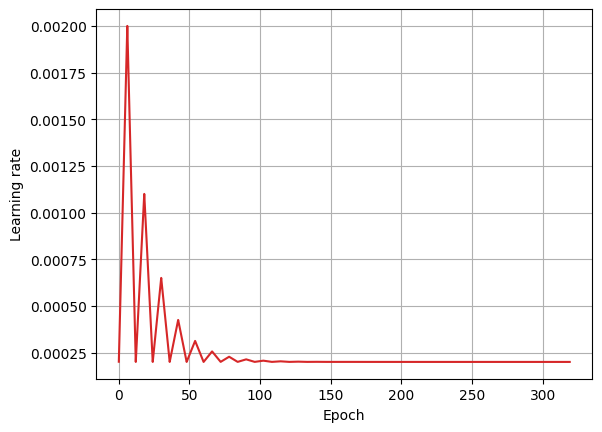

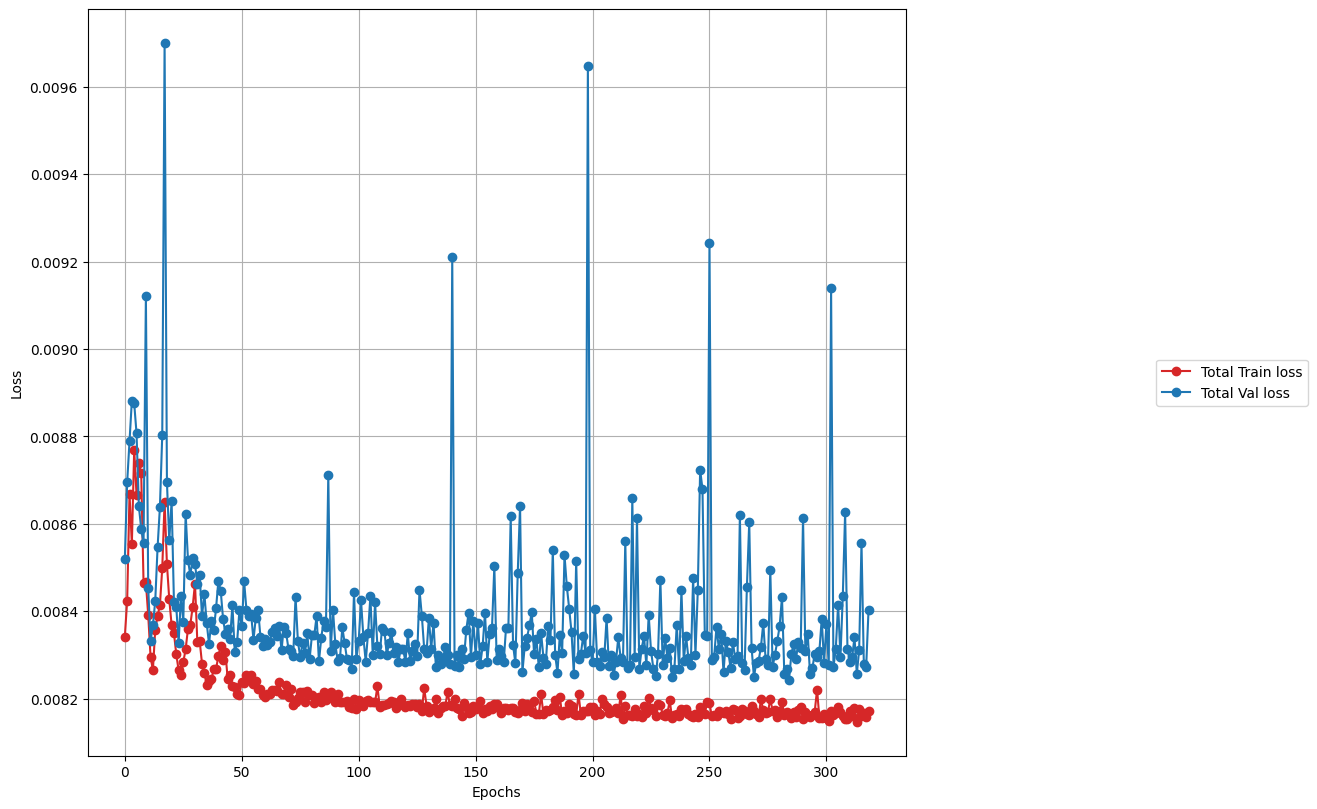

In [36]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()


<Figure size 640x480 with 0 Axes>

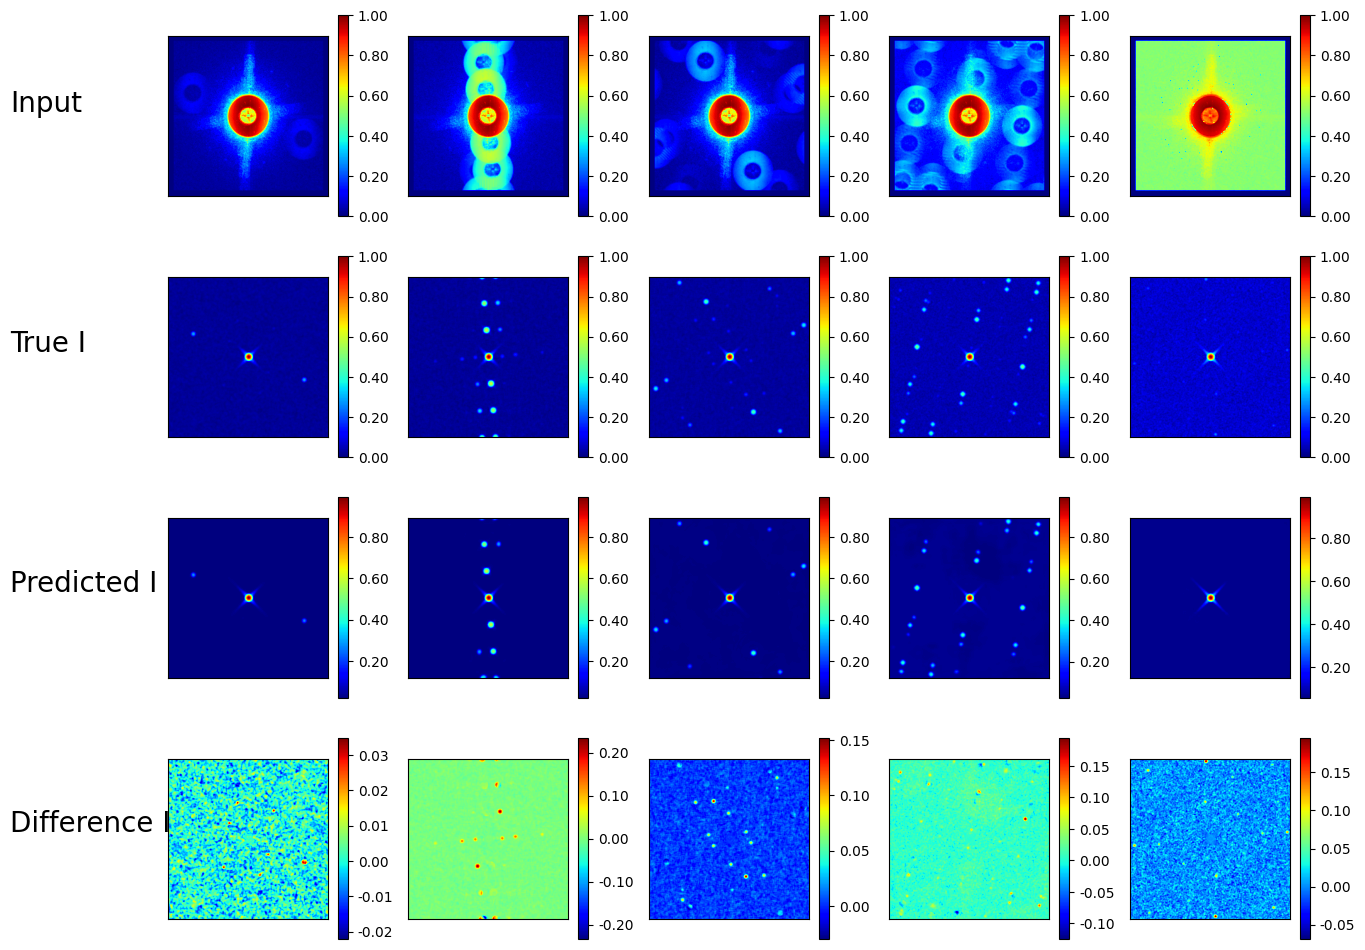

In [37]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)#,testsp)
    #result = model_new(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

In [94]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     997 MB |   13905 MB |  306782 GB |  306781 GB |
|       from large pool |     985 MB |   13889 MB |  306605 GB |  306604 GB |
|       from small pool |      11 MB |      19 MB |     177 GB |     177 GB |
|---------------------------------------------------------------------------|
| Active memory         |     997 MB |   13905 MB |  306782 GB |  306781 GB |
|       from large pool |     985 MB |   13889 MB |  306605 GB |

# Load saved model

In [95]:
#Load lowest validation loss model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new=recon_model()
#model_new.load_state_dict(torch.load("/mnt/micdata2/12IDC/ptychosaxs/trained_model/best_model.pth"))
#model_new.load_state_dict(torch.load("/mnt/micdata2/12IDC/ptychosaxs/models/best_model_Unet_chansong.pth"))
#model_new.load_state_dict(torch.load(path+"/models/best_model_Unet_cindy.pth"))
#model_new.load_state_dict(torch.load("/mnt/micdata2/12IDC/ptychosaxs/trained_model/best_model_cindy_diff.pth"))
model_new.load_state_dict(torch.load(path+"/trained_model/best_model_cindy_diff.pth"))
model_new.to(device)

#put into eval mode for testing
model_new.eval()

# #Load lowest validation loss model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_new2=recon_model()
# #model_new2.load_state_dict(torch.load("/mnt/micdata2/12IDC/ptychosaxs/models/best_model_cindy_diff_sim8_20000dps_96epochs.pth"))
# model_new2.load_state_dict(torch.load(path+"/ptychosaxs/models/best_model_cindy_diff_sim11_14400dps.pth"))
# model_new2.to(device)

# #put into eval mode for testing
# model_new2.eval()

recon_model(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): R

In [101]:
model.eval() #imp when have dropout etc
model_new.eval()
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    #testsp = test[1].to(device)
    result = model_new(tests)#,testsp)
    #result = model(tests,testsp)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()


h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w),clim=(0.1,1))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f35b0584310>
Traceback (most recent call last):
  File "/home/beams/PTYCHOSAXS/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/beams/PTYCHOSAXS/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib64/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib64/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib64/python3.9/multiprocessing/connection.py", line 935, in wait
    ready = selector.select(timeout)
  File "/usr/lib64/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

# Cindy Zheng data

In [ ]:
save_results=False
if save_results:
    np.savez('results_conv_deconvML_256x256_2encoder_cindy_0pt00493valLoss.npz',conv=conv_cindy,deconvML=results_deconv_cindy,probeML=probe_cindy)

In [43]:
#Full scan diffraction patterns
full_dps=np.load('/mnt/micdata2/12IDC/ptychosaxs/data/cindy_scan_diffraction_patterns.npy',mmap_mode='r')


In [33]:
full_dps.shape

(33264, 514, 1030)

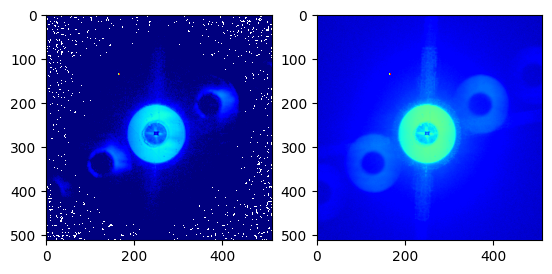

(512, 512)

In [34]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(full_dps[(1671-1537)*(12*11)+59][1:513,259:771],norm=colors.LogNorm())
ax[1].imshow(np.sum(np.asarray([full_dps[(1671-1537)*(12*11)+i][1:513,259:771] for i in range(0,132)]),axis=0),norm=colors.LogNorm())
plt.show()
full_dps[10][1:513,259:771].shape

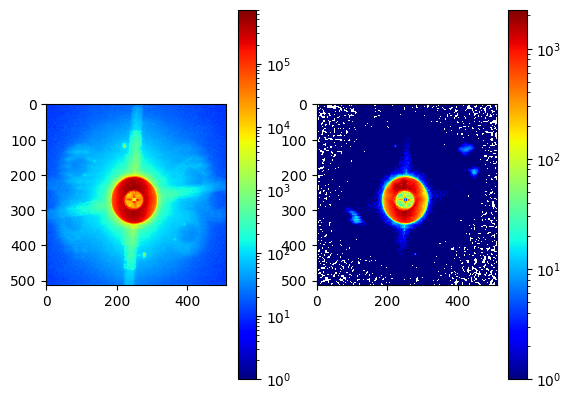

In [96]:
#full_dps1671=np.load('/mnt/micdata2/12IDC/ptychosaxs/data/cindy6_scan1671_diffraction_patterns.npy')

#scans saved [1083,1098,1115,1125]
scan=1083
filename=path+f'/data/cindy_scan{scan}_diffraction_patterns.npy'
full_dps1671_orig=np.load(filename,mmap_mode='r')
full_dps1671=full_dps1671_orig.copy()
for dp_pp in full_dps1671:
    dp_pp[dp_pp >= 2**16-1] = np.min(dp_pp) #get rid of hot pixel

index=168#random.randint(0,len(full_dps1671))#59
dps1671_index=np.asarray(full_dps1671[index][1:513,259:771])
dps1671_copy=np.sum(full_dps1671[:,1:513,259:771],axis=0)#/len(dps1671_copy)
fig,ax=plt.subplots(1,2)
im1=ax[0].imshow(dps1671_copy,norm=colors.LogNorm())
plt.colorbar(im1)
im2=ax[1].imshow(dps1671_index,norm=colors.LogNorm())
plt.colorbar(im2)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [01:18<00:00,  5.20s/it]


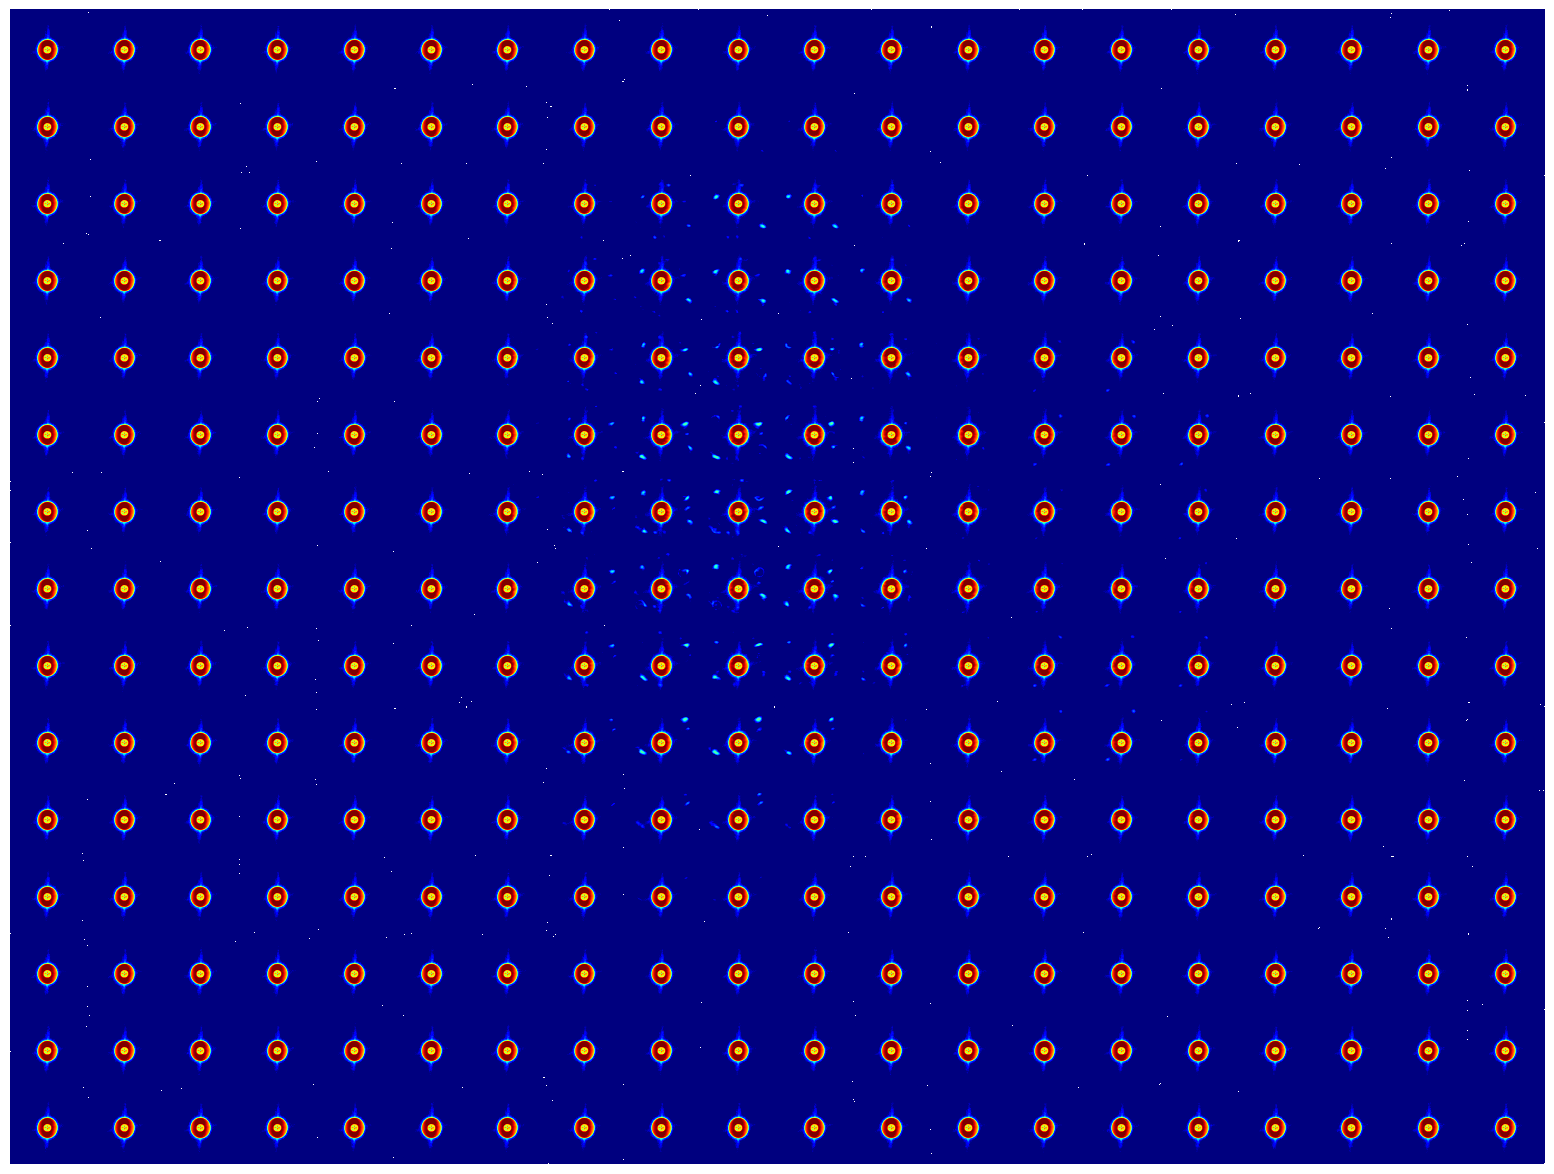

In [38]:
#fig, axs = plt.subplots(12,11, sharex=True,sharey=True,figsize=(10.9,12))
fig, axs = plt.subplots(15,20, sharex=True,sharey=True,figsize=(20-0.2,15))
# Remove vertical space between Axes
fig.subplots_adjust(hspace=0,wspace=0)
count=0
II=[]
# for i in range(0,12):
#     for j in range(0,11):
for i in tqdm(range(0,15)):
    for j in range(0,20):
        # Plot each graph, and manually set the y tick values
        axs[i][j].imshow(full_dps1671[count][1:513,259:771],norm=colors.LogNorm(),cmap='jet',clim=(1,1000))
        axs[i][j].axis("off")
        II.append(np.sum(full_dps1671[count][1:513,259:771]))
        count+=1
plt.show()
II=np.asarray(II)


In [36]:
# Create a distance map to focus away from the center (
height, width = full_dps1671[0][1:513,259:771].shape
center_y, center_x = height // 2-10, width // 2+13
y_coords, x_coords = np.meshgrid(np.arange(height, dtype=np.float32), 
                                    np.arange(width, dtype=np.float32))

# Calculate the distance from the center for each pixel (float type)
qpixel=(2/height) #2 length^(-1) per pixel
distance_map = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)*qpixel  #q distance map

In [33]:
# index=126#random.randint(0,len(full_dps1671))
# print(index)
# dps1671_index=np.asarray(full_dps1671[index][1:513,259:771])
# dps1671_sum=np.sum(np.asarray([full_dps1671[i][1:513,259:771] for i in range(0,132)]),axis=0)


# dps1671_index_copy=dps1671_index.copy()
# dps1671_index_copy=np.asarray(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_row_indices(replace_2d_array_values_by_row_indices(dps1671_index_copy,0,16),495,511),0,16),495,511))

# size=256

# dps1671_index_copy[np.isnan(dps1671_index_copy)] = 0
# #dps1671_index_copy[dps1671_index_copy <= 0] = np.min(dps1671_index_copy[dps1671_index_copy > 0])  # small positive value
# #dps1671_index_copy[dps1671_index_copy >= 2**16-1] = np.min(dps1671_index_copy)#np.max(dps1671_index_copy[dps1671_index_copy < 2**16-1])  # largest positive value that isnt one singular pixel of stb
# dps1671_index_copy=dps1671_index_copy*distance_map**4
# dps1671_index_copy=np.log10(dps1671_index_copy+np.min(dps1671_index_copy[dps1671_index_copy>0]))
# dps1671_index_copy=np.asarray((dps1671_index_copy-np.min(dps1671_index_copy))/(np.max(dps1671_index_copy)-np.min(dps1671_index_copy)))
# tests_new_res=np.asarray(resize(dps1671_index_copy[:,:],(size,size),preserve_range=True,anti_aliasing=True))

# blah1=torch.tensor(tests_new_res.reshape(1,1,size,size))

# blah1a=blah1.to(device=device, dtype=torch.float)



# fig,ax=plt.subplots(1,2,figsize=(15,5))
# im0=ax[0].imshow(blah1[0][0])#,clim=(0.12,1))
# im1=ax[1].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0.2,.5))
# #im1=ax[1].imshow(model(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.2))
# plt.colorbar(im0)
# plt.colorbar(im1)
# plt.show()




# dps1671_copy=dps1671_sum.copy()
# dps1671_copy=np.asarray(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_row_indices(replace_2d_array_values_by_row_indices(dps1671_copy,0,16),495,511),0,16),495,511))

# size=256


# dps1671_copy[np.isnan(dps1671_copy)] = 0
# dps1671_copy[dps1671_copy <= 0] = np.min(dps1671_copy[dps1671_copy > 0])  # small positive value
# dps1671_copy[dps1671_copy >= 2**16-1] = np.max(dps1671_copy[dps1671_copy < 2**16-1])  # largest positive value that isnt one singular pixel of stb
# dps1671_copy=dps1671_copy*distance_map**2
# dps1671_copy=np.log10(dps1671_copy+np.min(dps1671_copy[dps1671_copy>0]))
# dps1671_copy=np.asarray((dps1671_copy-np.min(dps1671_copy))/(np.max(dps1671_copy)-np.min(dps1671_copy)))
# tests_new_res=np.asarray(resize(dps1671_copy[:,:],(size,size),preserve_range=True,anti_aliasing=True))

# blah1=torch.tensor(tests_new_res.reshape(1,1,size,size))
# blah1a=blah1.to(device=device, dtype=torch.float)



# fig,ax=plt.subplots(1,2,figsize=(15,5))
# im0=ax[0].imshow(blah1[0][0])#,clim=(0.12,1))
# im1=ax[1].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.5))
# #im1=ax[1].imshow(model(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.6))
# plt.colorbar(im0)
# plt.colorbar(im1)
# plt.show()


In [27]:
def create_circular_mask(image, center_x=0,center_y=0,radius=48):
    """
    Creates a circular mask at the center of the image.
    """
    # Get the dimensions of the image
    h, w = image.shape[:2]
    
    # Calculate the center of the image
    if center_x == 0 and center_y==0:
        center_x, center_y = w // 2, h // 2
    
    # Create a grid of x and y coordinates
    y, x = np.ogrid[:h, :w]
    
    # Calculate the distance from each pixel to the center
    distance_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    
    # Create the circular mask
    mask = distance_from_center >= radius
    
    return mask.astype(np.uint8)  # Return as uint8 (0s and 1s)

In [97]:
def preprocess_cindy(dp):
    size=256
    dp_pp=np.asarray(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_column_indices(replace_2d_array_values_by_row_indices(replace_2d_array_values_by_row_indices(dp,0,16),495,511),0,16),495,511))
    dp_pp[np.isnan(dp_pp)] = 0
    #dp_pp=create_circular_mask(dp_pp,center_x=125*2,center_y=135*2,radius=48*2)*dp_pp
    dp_pp[dp_pp <= 0] = np.min(dp_pp[dp_pp > 0])# small positive value
    dp_pp=np.asarray(resize(dp_pp[:,:],(size,size),preserve_range=True,anti_aliasing=True))
    dp_pp=np.log10(dp_pp)
    
    sf=np.max(dp_pp)-np.min(dp_pp)
    bkg=np.min(dp_pp)
    dp_pp=np.asarray((dp_pp-bkg)/(sf))
    dp_pp=torch.tensor(dp_pp.reshape(1,1,size,size))
    return dp_pp,sf,bkg

def invert_preprocess_cindy(dp,sf,bkg):
    dp_rec=dp*sf + bkg
    dp_rec=10**(dp_rec)
    return dp_rec

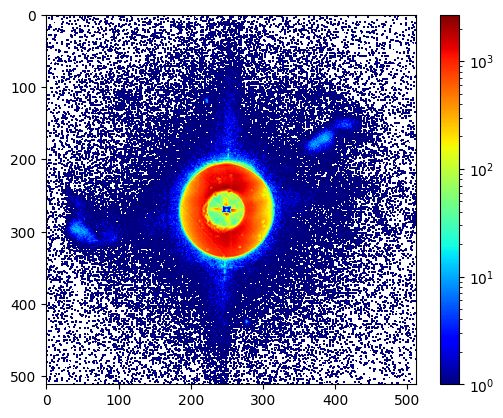

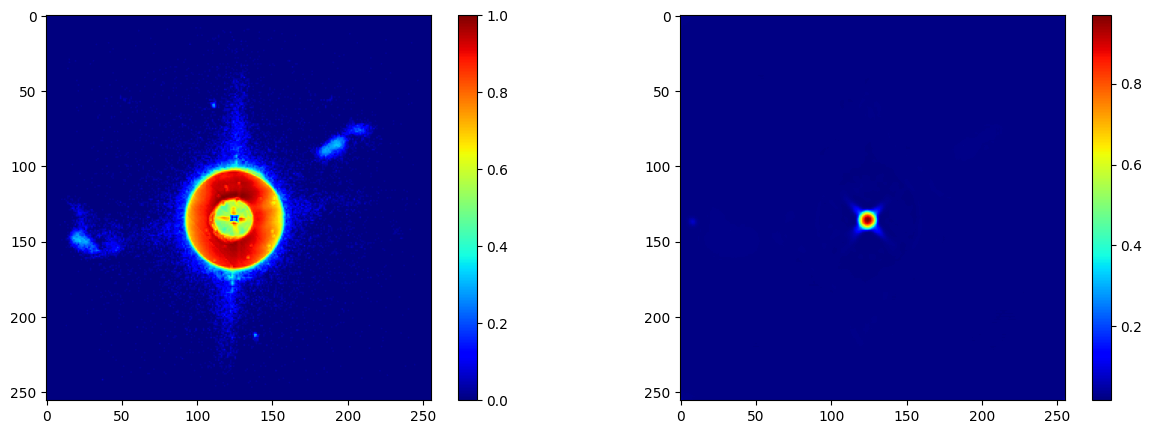

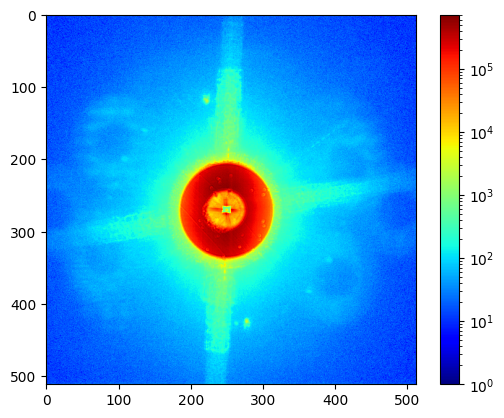

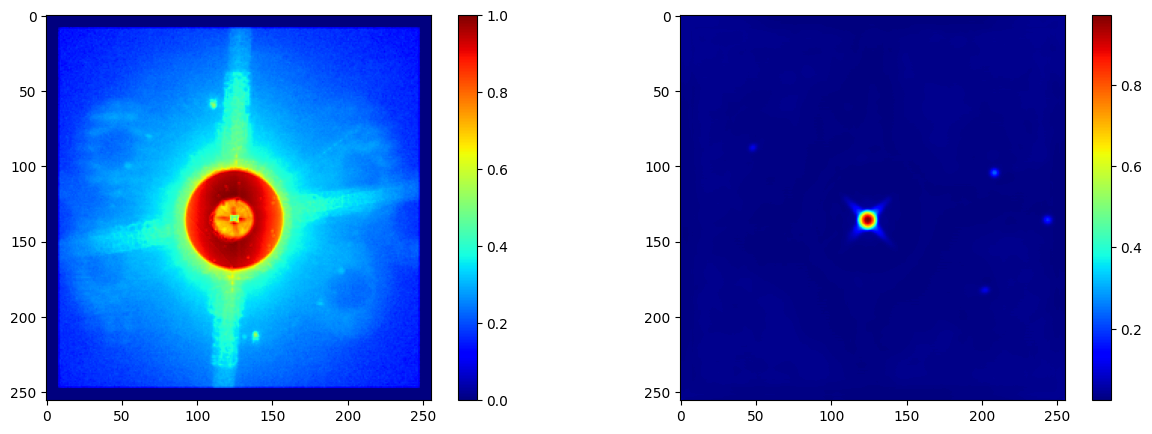

In [98]:
index=190#random.randint(0,len(full_dps1671))
dps1671_index=np.asarray(full_dps1671[index][1:513,259:771])

dps1671_index_copy=dps1671_index.copy()#*distance_map
plt.imshow(dps1671_index_copy,norm=colors.LogNorm())
plt.colorbar()
blah1,sf,bkg=preprocess_cindy(dps1671_index_copy)
blah1a=blah1.to(device=device, dtype=torch.float)
fig,ax=plt.subplots(1,2,figsize=(15,5))
im0=ax[0].imshow(blah1[0][0])#,clim=(0.12,1))
im1=ax[1].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0.3,.4))
#im1=ax[1].imshow(model(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.2))
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()


dps1671_copy=np.sum(full_dps1671[:,1:513,259:771],axis=0)#/len(full_dps1671)
plt.imshow(dps1671_copy,norm=colors.LogNorm())
plt.colorbar()
blah1,sfT,bkgT=preprocess_cindy(dps1671_copy)
blah1a=blah1.to(device=device, dtype=torch.float)
fig,ax=plt.subplots(1,2,figsize=(15,5))
im0=ax[0].imshow(blah1[0][0])#,clim=(0.12,1))
im1=ax[1].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0.2,.6))
#im1=ax[1].imshow(model(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.6))
plt.colorbar(im0)
plt.colorbar(im1)
plt.show()


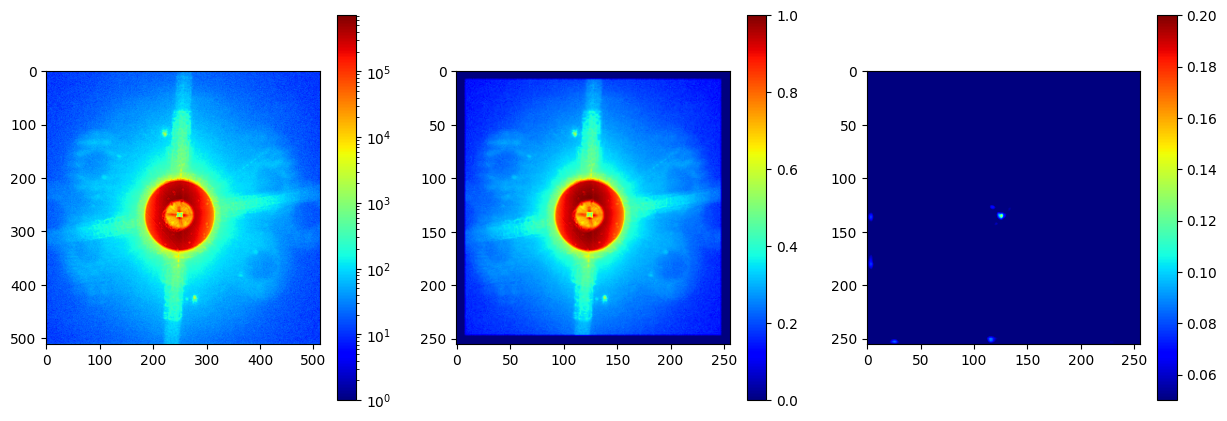

In [45]:

fig,ax=plt.subplots(1,3,figsize=(15,5))

dps1671_copy=np.sum(full_dps1671[:,1:513,259:771],axis=0)#*distance_map**0.95#/len(full_dps1671)
im1=ax[0].imshow(dps1671_copy,norm=colors.LogNorm())
plt.colorbar(im1)
blah1,sf,bkg=preprocess_cindy(dps1671_copy)
blah1a=blah1.to(device=device, dtype=torch.float)
im2=ax[1].imshow(blah1[0][0])#,clim=(0.12,1))
im3=ax[2].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0],clim=(0.05,.2))
#im1=ax[1].imshow(model(blah1a).detach().to("cpu").numpy()[0][0])#,clim=(0,.6))
plt.colorbar(im2)
plt.colorbar(im3)


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [02:33<00:00, 10.25s/it]


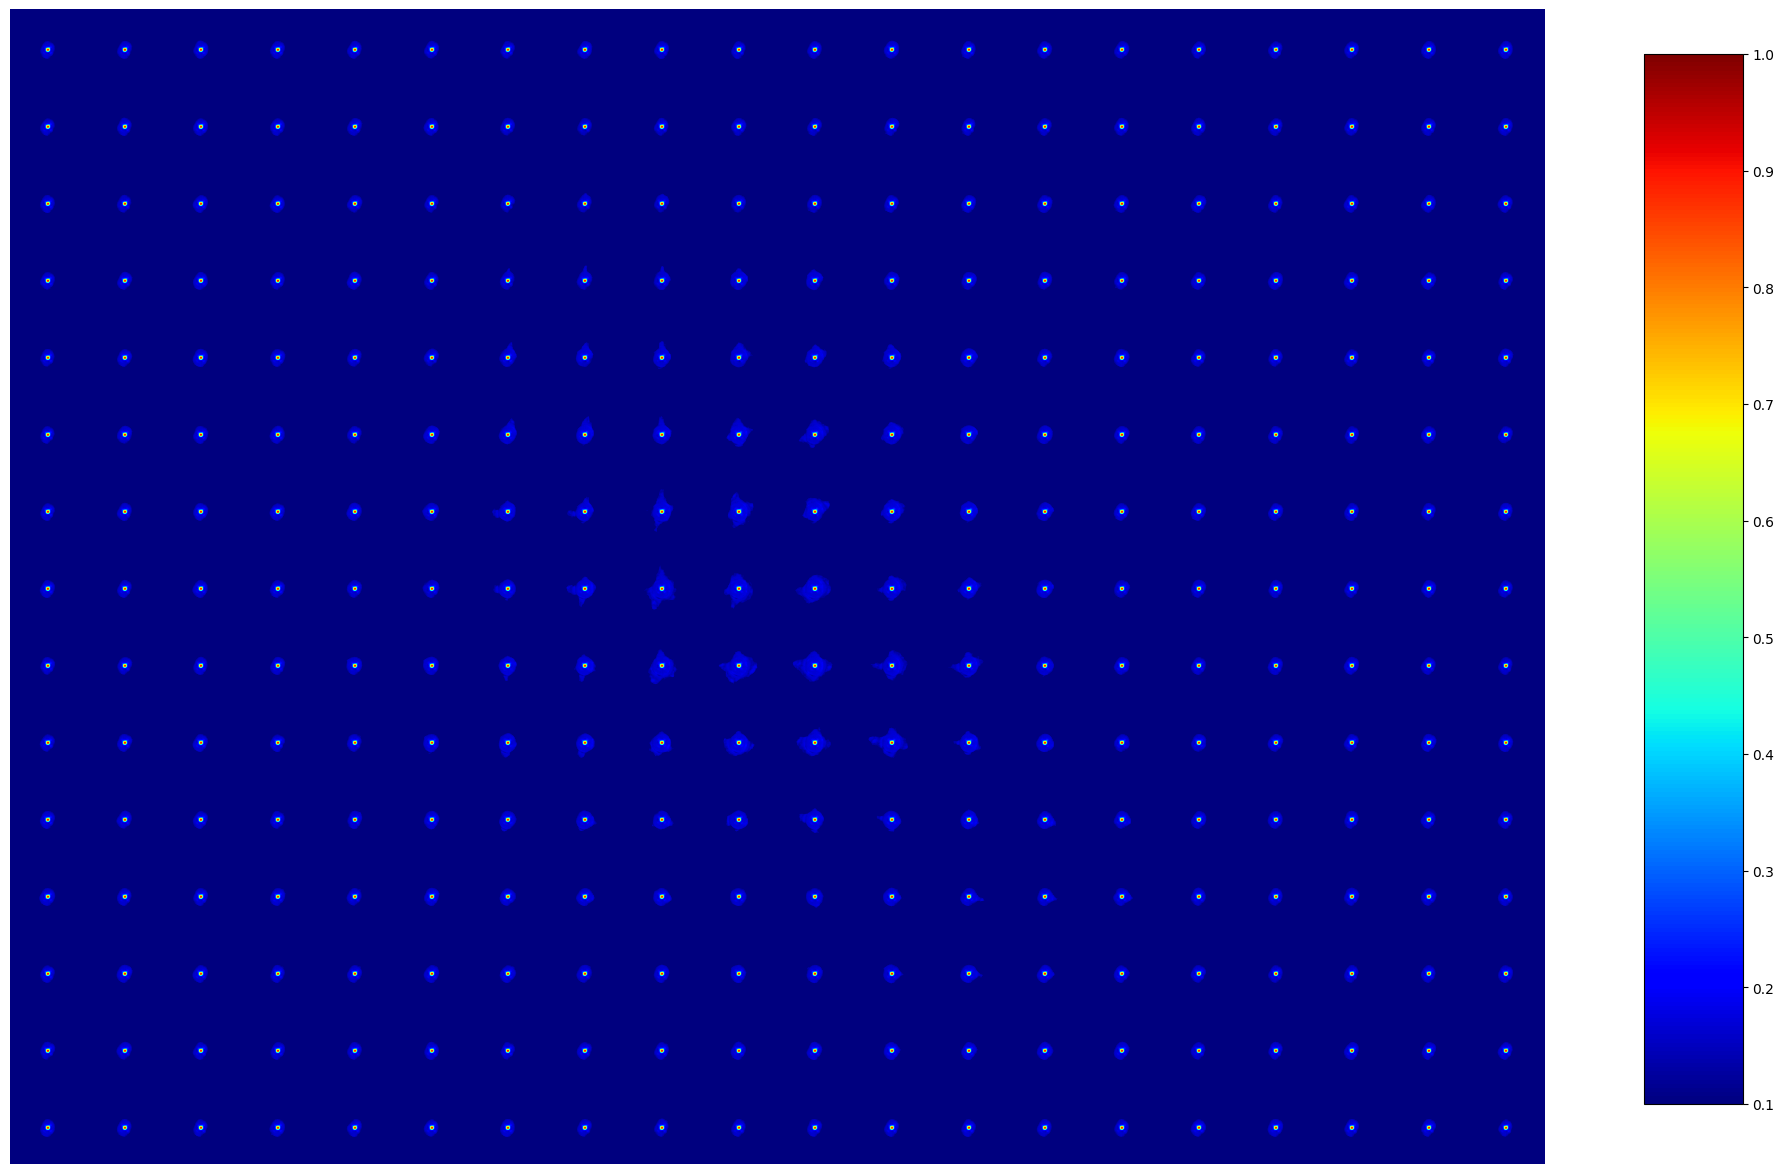

In [45]:
#fig, axs = plt.subplots(12,11, sharex=True,sharey=True,figsize=(10.9,12))
fig, axs = plt.subplots(15,20, sharex=True,sharey=True,figsize=(20-0.2,15))

# Remove vertical space between Axes
fig.subplots_adjust(hspace=0,wspace=0)

# fig2, axs2 = plt.subplots(12,11, sharex=True,sharey=True,figsize=(10.9,12))
# # Remove vertical space between Axes
# fig2.subplots_adjust(hspace=0,wspace=0)
count=0

inputs=[]
outputs=[]
sfs=[]
bkgs=[]

# for i in tqdm(range(0,12)):
#     for j in range(0,11):
for i in tqdm(range(0,15)):
    for j in range(0,20):
        dps1671_count=np.asarray(full_dps1671[count][1:513,259:771])
      
        dps1671_count_copy=dps1671_count.copy()
        blah1,sf,bkg=preprocess_cindy(dps1671_count_copy)
        blah1a=blah1.to(device=device, dtype=torch.float)

        result=model_new(blah1a).detach().to("cpu").numpy()[0][0]
        
        #im=axs[i][j].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0]-model_new2(blah1a).detach().to("cpu").numpy()[0][0],clim=(-.3,.3))
        #axs[i][j].imshow(model_new(blah1a).detach().to("cpu").numpy()[0][0]-model_new2(blah1a).detach().to("cpu").numpy()[0][0],clim=(-.3,.3))
        im=axs[i][j].imshow(result,clim=(0.1,1))
        axs[i][j].imshow(result,clim=(0.1,1))
        #axs[i][j].imshow(model(blah1a).detach().to("cpu").numpy()[0][0],clim=(0,0.8))
        #axs[i][j].imshow(full_dps1671[count][1:513,259:771],norm=colors.LogNorm(),cmap='jet',clim=(1,1000))
        axs[i][j].axis("off")

        outputs.append(result)
        sfs.append(sf)
        bkgs.append(bkg)
        inputs.append(blah1a.detach().to("cpu").numpy()[0][0])
        
        count+=1
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


In [104]:
save=False
if save:
    np.savez(f'/mnt/micdata2/12IDC/ptychosaxs/results/results_cindy3_scan{scan}_diff_sim11_conv_deconvML.npz',convDP=np.asarray(inputs),pinholeDP=np.asarray(outputs))

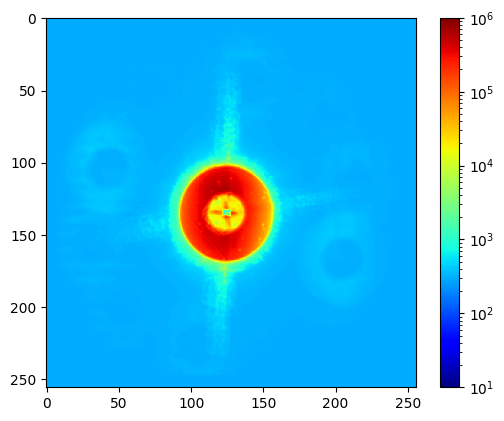

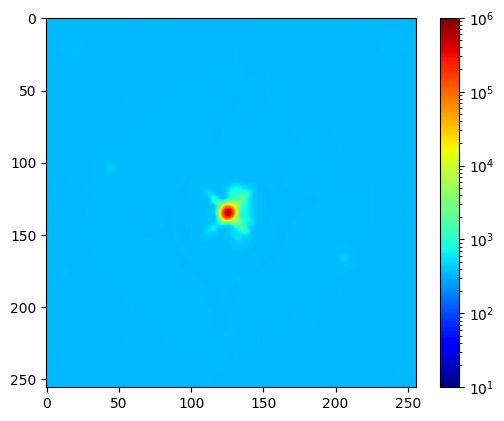

In [31]:
scale=1
plt.imshow(np.sum(np.asarray([invert_preprocess_cindy(inputs[i],sfs[i]*scale,bkgs[i]) for i in range(0,len(inputs))]),axis=0),norm=colors.LogNorm(),clim=(1e1,1e6))
plt.colorbar()
plt.show()
plt.imshow(np.sum(np.asarray([invert_preprocess_cindy(outputs[i],sfs[i]*scale,bkgs[i]) for i in range(0,len(inputs))]),axis=0),norm=colors.LogNorm(),clim=(1e1,1e6))
plt.colorbar()
plt.show()

(300, 256, 256)

In [65]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        # Hook to capture gradients during backpropagation
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook to capture activations during forward pass
        def forward_hook(module, input, output):
            self.activations = output

        # Register the hooks for the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def forward(self, input_tensor, true_label):
        """ Forward pass and compute the MAE """
        output = self.model(input_tensor)

        # Compute the Mean Absolute Error (MAE) between output and true label
        loss = torch.mean(torch.abs(output - true_label))

        # Zero the gradients and backpropagate the loss to get the gradients
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        return loss

    def generate_cam(self):
        """ Generate the Grad-CAM heatmap """
        # Global average pooling of gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the activations with the pooled gradients
        weighted_activations = self.activations * pooled_gradients.unsqueeze(1).unsqueeze(2)

        # Sum the activations along the channel dimension to get the heatmap
        heatmap = torch.sum(weighted_activations, dim=1).squeeze()

        # Apply ReLU to remove negative values
        heatmap = torch.relu(heatmap)

        # Normalize the heatmap between 0 and 1
        heatmap = heatmap - heatmap.min()
        heatmap = heatmap / heatmap.max()

        return heatmap.cpu().detach().numpy()

    def __del__(self):
        """ Remove the hooks when done """
        for handle in self.hook_handles:
            handle.remove()

def overlay_heatmap_on_image(heatmap, image, alpha=0.5):
    """ Overlay the heatmap on the input image """
    heatmap_resized = np.resize(heatmap, (image.shape[0], image.shape[1]))  # Resize heatmap to image size
    heatmap_colored = heatmap_resized #plt.cm.jet(heatmap_resized)[:, :, 1]  # Convert heatmap to RGB colors
    overlay = alpha * heatmap_colored + (1 - alpha) * image  # Blend heatmap and image
    return overlay



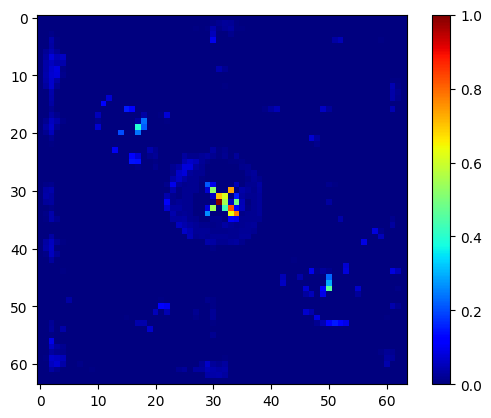

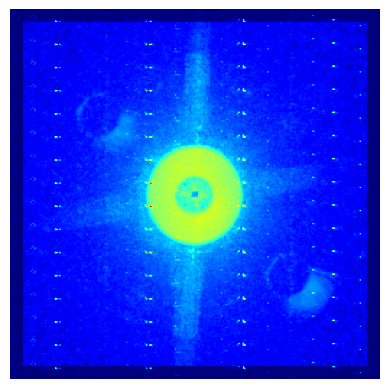

In [77]:
# Initialize the model and Grad-CAM
#target_layer = model.module.encoder3#1,2,3  # Choose a convolutional layer from the encoder
#target_layer = model.module.decoder2#2,3,4
#target_layer = model.module.conv_last
#target_layer = model.module.bottleneck
grad_cam = GradCAM(model, target_layer)


index=258
# Prepare an input tensor (e.g., a batch of images) and its corresponding true label
input_tensor = torch.tensor(np.float32(X_test[index])).reshape(1,1,256,256)#torch.randn(1, 1, 256, 256)  # Example input (e.g., 1 image)
true_label = torch.tensor(np.float32(Y_I_test[index])).reshape(1,1,256,256)#torch.randn(1, 1, 256, 256)  # Example true label for the input

# Perform forward and backward pass to compute the gradients based on MAE
loss = grad_cam.forward(input_tensor.to(device), true_label=true_label.to(device))

# Generate the Grad-CAM heatmap
heatmap = grad_cam.generate_cam()

# Display the heatmap using matplotlib
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# Overlay the heatmap on the input image
overlay = overlay_heatmap_on_image(heatmap, X_test[index][0])

# Display the result
plt.imshow(overlay)
plt.axis('off')
plt.show()

258


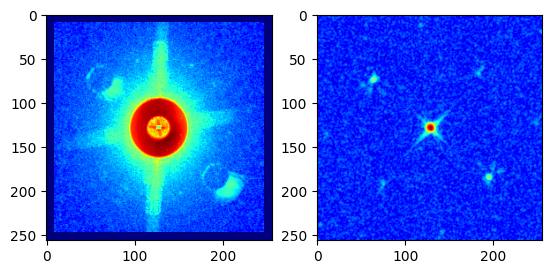

In [67]:
fig,ax=plt.subplots(1,2)
ri=258#random.randint(0,len(X_test))#257
print(ri)
im1=ax[0].imshow(X_test[ri][0,:,:])
im2=ax[1].imshow(Y_I_test[ri][0,:,:])
plt.show()

In [68]:
h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 3
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=257+i

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

AttributeError: 'list' object has no attribute 'shape'